<a href="https://colab.research.google.com/github/RogerioMatos75/3D_Fusion_AI/blob/main/3D_Fusion_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install numpy opencv-python-headless scikit-image trimesh
print("Bibliotecas instaladas com sucesso!")

# Task
Refactor the provided Python code in Google Colab to implement a 3D reconstruction pipeline using the Visual Hull and Marching Cubes algorithms, based on the steps outlined in the `Readme.md` file. The pipeline should take multiple silhouette images as input, reconstruct a 3D model, and export it as a `.glb` file.

## Preparar o ambiente e carregar dados

### Subtask:
Adaptar o carregamento de imagens para lidar com múltiplas vistas/silhuetas (seja carregando vários arquivos ou simulando-os).


In [18]:
%pip install trimesh
print("Biblioteca trimesh instalada com sucesso!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 735.5/735.5 kB 11.1 MB/s eta 0:00:00
Biblioteca trimesh instalada com sucesso!


In [21]:
from google.colab import files
import os
import zipfile
import json

print("Por favor, carregue o arquivo .ZIP contendo as silhuetas e o metadata.json")
uploaded = files.upload()

# Assume a single zip file is uploaded
if uploaded:
    zip_file_name = list(uploaded.keys())[0]
    print(f"Arquivo '{zip_file_name}' carregado.")

    # Define the path where the zip file is located in the Colab environment
    # files.upload() places the file in the current working directory (/content/)
    zip_file_path = os.path.join('/content/', zip_file_name)

    # Create a directory to extract files into
    extract_path = '/content/uploaded_data'
    os.makedirs(extract_path, exist_ok=True)
    print(f"Tentando descompactar '{zip_file_name}' para '{extract_path}'...")


    try:
        # Check if the uploaded file is indeed a zip file before attempting to open
        if zipfile.is_zipfile(zip_file_path):
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            print(f"Arquivo descompactado com sucesso para '{extract_path}'.")

            # Now, let's look for the metadata.json and list other files
            metadata_path = os.path.join(extract_path, 'metadata.json')
            if os.path.exists(metadata_path):
                print("\nArquivo metadata.json encontrado:")
                try:
                    with open(metadata_path, 'r') as f:
                        metadata = json.load(f)
                    print("Conteúdo do metadata.json (primeiros itens):")
                    # Display first few items or structure
                    import pprint
                    pprint.pprint(metadata)

                    # Store metadata and extracted file path for later use
                    uploaded_metadata = metadata
                    extracted_files_path = extract_path

                except Exception as e:
                    print(f"Erro ao ler ou analisar metadata.json: {e}")
                    uploaded_metadata = None
                    extracted_files_path = extract_path # Still keep path to other files

            else:
                print("\nArquivo metadata.json NÃO encontrado no ZIP.")
                uploaded_metadata = None
                extracted_files_path = extract_path # Still keep path to other files


            print("\nOutros arquivos descompactados (limitado a 10 para brevidade):")
            # List files in the extracted directory (limit output)
            count = 0
            for root, dirs, files_in_dir in os.walk(extract_path):
                for file in files_in_dir:
                    if count < 10:
                        print(os.path.join(root, file).replace(extract_path, '')) # Print path relative to extracted_path
                        count += 1
                    else:
                        print("...")
                        break
                if count >= 10:
                    break


        else:
             print(f"Erro: O arquivo carregado '{zip_file_name}' não parece ser um arquivo ZIP válido.")
             extracted_files_path = None
             uploaded_metadata = None


    except Exception as e:
        print(f"Ocorreu um erro inesperado durante a descompactação ou processamento: {e}")
        extracted_files_path = None
        uploaded_metadata = None

else:
    print("\nNenhum arquivo foi carregado.")
    extracted_files_path = None
    uploaded_metadata = None

Por favor, carregue o arquivo .ZIP contendo as silhuetas e o metadata.json


Saving Both_Tenente_Taser.zip to Both_Tenente_Taser (3).zip
Arquivo 'Both_Tenente_Taser (3).zip' carregado.
Tentando descompactar 'Both_Tenente_Taser (3).zip' para '/content/uploaded_data'...
Arquivo descompactado com sucesso para '/content/uploaded_data'.

Arquivo metadata.json encontrado:
Conteúdo do metadata.json (primeiros itens):
{'frames': [{'camera_pose': {'lookAt': {'x': 0, 'y': 0, 'z': 0},
                             'position': {'x': 0, 'y': 0, 'z': 2},
                             'up': {'x': 0, 'y': 1, 'z': 0}},
             'file_name': '0_front.png'},
            {'camera_pose': {'lookAt': {'x': 0, 'y': 0, 'z': 0},
                             'position': {'x': -1.4142135623730951,
                                          'y': 0,
                                          'z': 1.4142135623730951},
                             'up': {'x': 0, 'y': 1, 'z': 0}},
             'file_name': '1_front_left.png'},
            {'camera_pose': {'lookAt': {'x': 0, 'y': 0, 'z': 0},
  


Running pipeline with extracted data and metadata.
--- Starting 3D Reconstruction Pipeline ---
Using voxel grid size: 150x150x150
Using volume bounds: {'x_min': -1.5, 'x_max': 1.5, 'y_min': -1.5, 'y_max': 1.5, 'z_min': -1.5, 'z_max': 1.5}
Using Marching Cubes level: 127
Show previews: True

Step 1: Loading images from directory...
Loading images from directory: /content/uploaded_data/silhouette...
Successfully loaded 0_front.png.
Successfully loaded 1_front_left.png.
Successfully loaded 2_left.png.
Successfully loaded 3_back_left.png.
Successfully loaded 4_back.png.
Successfully loaded 5_back_right.png.
Successfully loaded 6_right.png.
Successfully loaded 7_top.png.
Successfully loaded 8_bottom.png.
Finished loading 9 images.

Matching metadata with image files...
Matched and loaded image for 0_front.png.
Matched and loaded image for 1_front_left.png.
Matched and loaded image for 2_left.png.
Matched and loaded image for 3_back_left.png.
Matched and loaded image for 4_back.png.
Matched

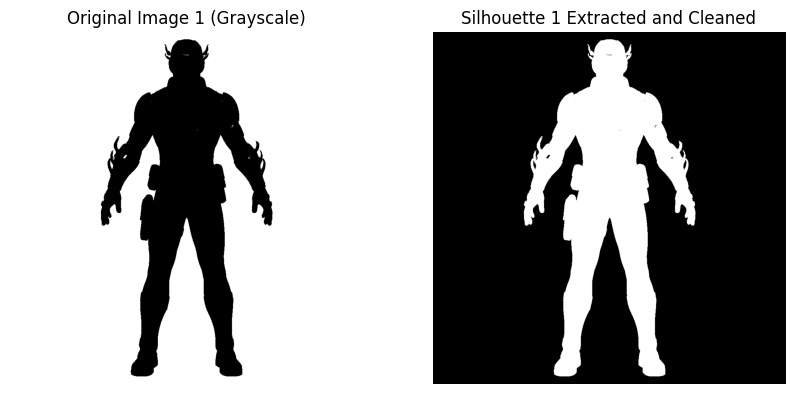

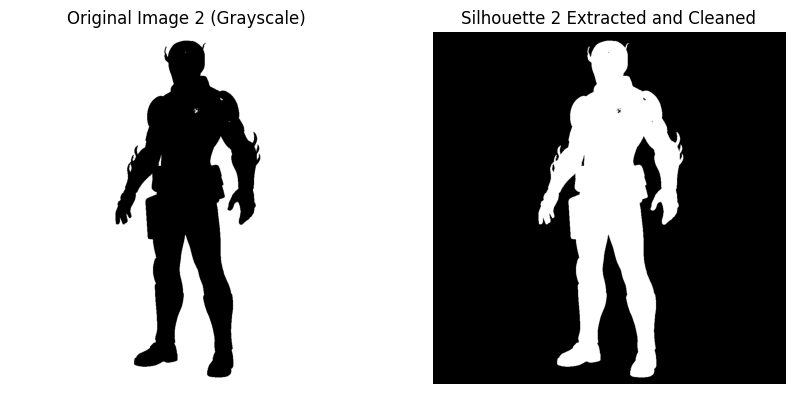

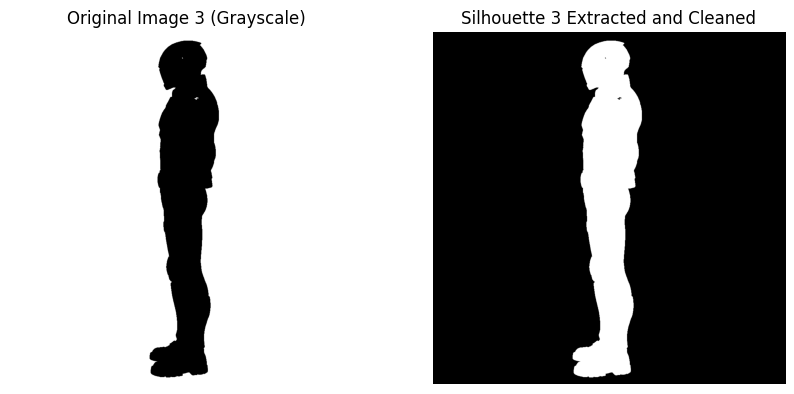

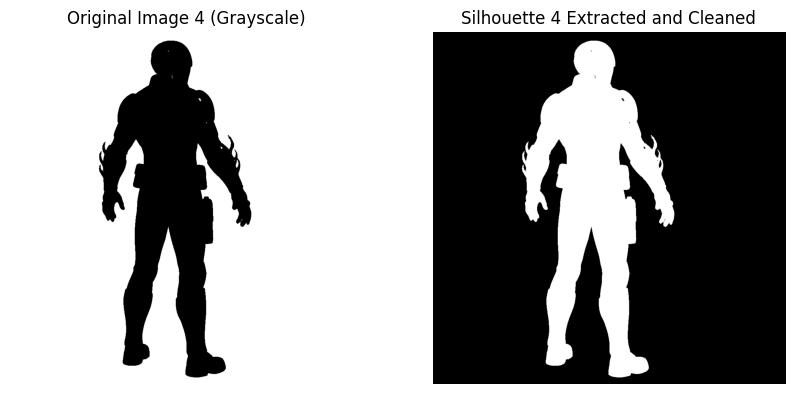

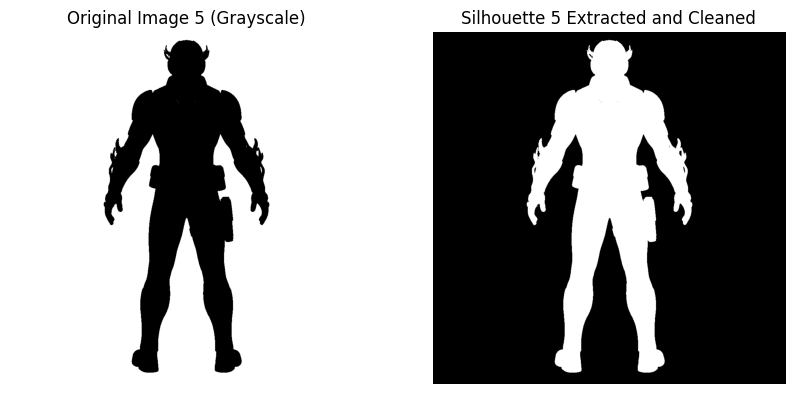

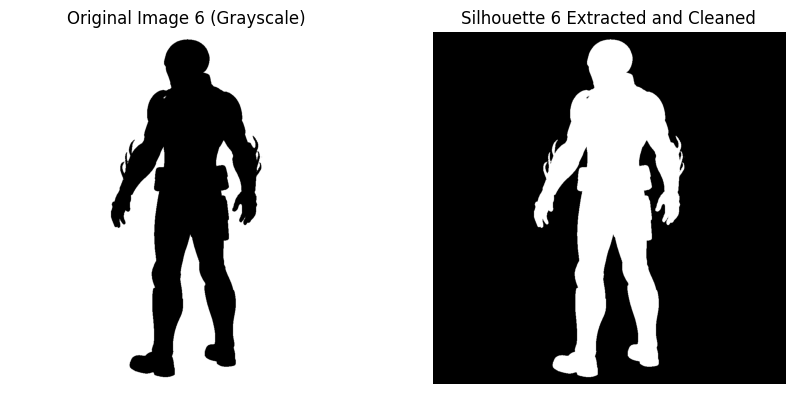

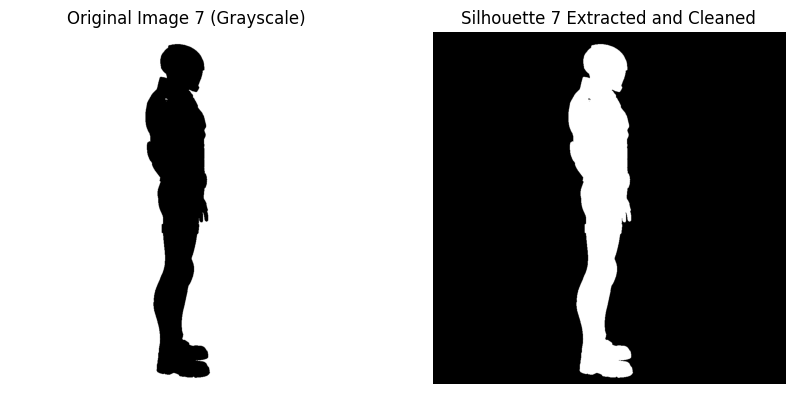

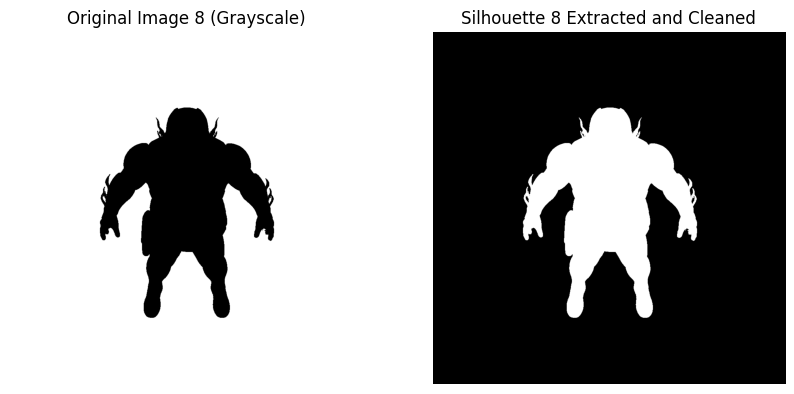

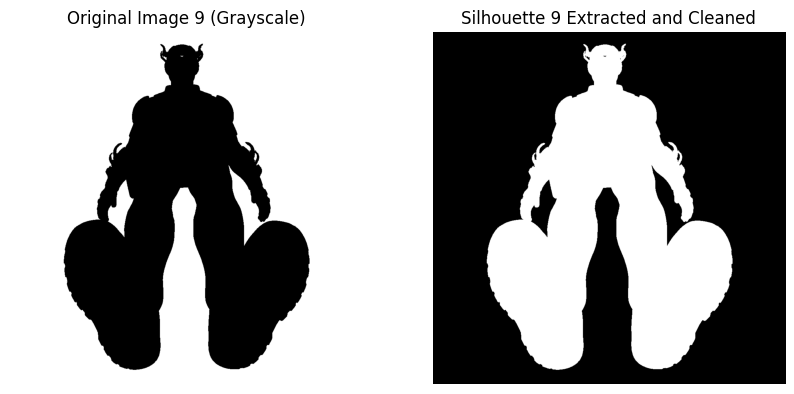

Finished processing 9 images and extracted silhouettes.

Step 3: Computing visual hull using metadata...
Computing visual hull using camera metadata...
An error occurred during visual hull computation: Cannot cast ufunc 'divide' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'
Visual hull computation failed or returned an invalid grid. Aborting pipeline.


In [26]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage import measure
import trimesh
import trimesh.repair
import trimesh.smoothing
import os
import json

# --- Function Definitions (Moved from Cell c3d08790) ---

# Modified load_images to read from a directory
def load_images_from_directory(directory_path):
    """
    Loads grayscale images from a specified directory. Assumes images are directly in the directory.

    Args:
        directory_path: The path to the directory containing the image files.

    Returns:
        A list of loaded grayscale images, and a list of their filenames, or empty lists if an error occurs or no images found.
    """
    images = []
    image_filenames = []
    print(f"Loading images from directory: {directory_path}...")
    if not os.path.isdir(directory_path):
        print(f"Error: Directory not found: {directory_path}")
        return images, image_filenames # Return empty lists

    try:
        # List all files in the directory
        all_files = os.listdir(directory_path)
        # Filter for common image file extensions (you might need to adjust this list)
        image_files = [f for f in all_files if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif']]

        if not image_files:
            print(f"Warning: No image files found in directory: {directory_path}")
            return images, image_filenames # Return empty lists

        # Sort files to maintain a consistent order, important for matching with metadata
        image_files.sort()

        for file_name in image_files:
            file_path = os.path.join(directory_path, file_name)
            # Read image in grayscale
            img_grayscale = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            if img_grayscale is None:
                print(f"Warning: Could not load image file: {file_name}")
                continue

            images.append(img_grayscale)
            image_filenames.append(file_name)
            print(f"Successfully loaded {file_name}.")

        print(f"Finished loading {len(images)} images.")
        return images, image_filenames
    except Exception as e:
        print(f"An error occurred during image loading from directory: {e}")
        return [], [] # Return empty lists in case of error


# Modified process_silhouettes to potentially include cleaning and previews
def process_silhouettes(images, show_previews=False):
    """
    Extracts silhouettes from a list of grayscale images with error handling,
    applies basic morphological operations for cleaning, and optionally displays previews.

    Args:
        images: A list of grayscale images.
        show_previews: If True, display the original grayscale image and the extracted silhouette.

    Returns:
        A list of silhouette images (binary masks), or None if an error occurs.
    """
    silhouettes = []
    print("Processing silhouettes...")
    if not images:
        print("No images provided for silhouette processing.")
        return silhouettes
    try:
        # Define kernel for morphological operations
        # A small kernel is usually sufficient for minor cleaning
        kernel = np.ones((3, 3), np.uint8)

        for i, img_grayscale in enumerate(images):
            # Ensure image is valid before processing
            if img_grayscale is None or img_grayscale.size == 0:
                print(f"Warning: Skipping processing for invalid image at index {i}.")
                continue

            # Apply binary inverse thresholding
            # Assuming the silhouettes from the zip are already binary (0 or 255)
            # We can still apply thresholding as a safety check or to ensure binary values
            # If images are already perfect binary, thresholding at a midpoint like 127 or 0.5 (if float) is needed.
            # Given the previous processing, let's assume thresholding at 240 is still relevant if input wasn't perfectly binary.
            _, silhouette = cv2.threshold(img_grayscale, 240, 255, cv2.THRESH_BINARY_INV)

            # --- Apply morphological operations for cleaning ---
            # Optional: Erosion followed by Dilation (Opening) to remove small objects/noise
            # Optional: Dilation followed by Erosion (Closing) to close small holes
            # The parameters (iterations) might need tuning based on the noise level
            # silhouette = cv2.erode(silhouette, kernel, iterations=1)
            # silhouette = cv2.dilate(silhouette, kernel, iterations=1)
            # Optional: Close small holes
            # silhouette = cv2.dilate(silhouette, kernel, iterations=1)
            # silhouette = cv2.erode(silhouette, kernel, iterations=1)
            # --- End of morphological operations ---


            silhouettes.append(silhouette)
            if show_previews:
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.title(f'Original Image {i+1} (Grayscale)')
                plt.imshow(img_grayscale, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.title(f'Silhouette {i+1} Extracted and Cleaned')
                plt.imshow(silhouette, cmap='gray')
                plt.axis('off')

                plt.show()

        print(f"Finished processing {len(silhouettes)} images and extracted silhouettes.")
        return silhouettes
    except Exception as e:
        print(f"An error occurred during silhouette processing: {e}")
        return None


# Modified project_voxel_to_silhouette to use camera parameters from metadata
def project_voxel_to_silhouette(voxel_coords, silhouette_shape, camera_data, volume_bounds, grid_size):
    """
    Projects a 3D voxel coordinate onto the 2D plane of a silhouette using camera parameters.

    Args:
        voxel_coords: Tuple (x, y, z) integer indices of the voxel in the grid.
        silhouette_shape: Tuple (height, width) of the silhouette image.
        camera_data: Dictionary containing camera pose information ('position', 'lookAt', 'up').
        volume_bounds: Dictionary defining the world coordinates bounds of the volume.
        grid_size: The size of the voxel grid (cubic).

    Returns:
        Tuple (proj_y, proj_x) pixel coordinates or (None, None) if projection is invalid.
    """
    # Convert voxel grid coordinates (integers) to world coordinates (floats)
    # Note: This assumes a linear mapping from grid index to world space within bounds
    voxel_world_x = volume_bounds['x_min'] + (voxel_coords[0] + 0.5) * (volume_bounds['x_max'] - volume_bounds['x_min']) / grid_size
    voxel_world_y = volume_bounds['y_min'] + (voxel_coords[1] + 0.5) * (volume_bounds['y_max'] - volume_bounds['y_min']) / grid_size
    voxel_world_z = volume_bounds['z_min'] + (voxel_coords[2] + 0.5) * (volume_bounds['z_max'] - volume_bounds['z_min']) / grid_size

    # Create the 3D point in world coordinates
    point_3d_world = np.array([voxel_world_x, voxel_world_y, voxel_world_z, 1.0]) # Homogeneous coordinates

    # --- Calculate Camera View Matrix (World to Camera) ---
    # Using camera position, lookAt, and up vectors
    camera_position = np.array([camera_data['position']['x'], camera_data['position']['y'], camera_data['position']['z']])
    look_at = np.array([camera_data['lookAt']['x'], camera_data['lookAt']['y'], camera_data['lookAt']['z']])
    up_vector = np.array([camera_data['up']['x'], camera_data['up']['y'], camera_data['up']['z']])

    # Calculate the camera's local axes
    forward = (look_at - camera_position)
    forward /= np.linalg.norm(forward)
    right = np.cross(forward, up_vector)
    right /= np.linalg.norm(right)
    # Recalculate up vector to ensure it's orthogonal to forward and right
    up = np.cross(right, forward)

    # Construct the view matrix
    # This matrix transforms points from world space to the camera's local space
    view_matrix = np.identity(4)
    view_matrix[:3, 0] = right
    view_matrix[:3, 1] = up
    view_matrix[:3, 2] = -forward # Cameras look down their negative Z axis
    view_matrix[:3, 3] = -np.dot(view_matrix[:3, :3], camera_position) # Translation

    # --- Calculate Projection Matrix (Camera to Clip Space) ---
    # This is a placeholder for a perspective projection matrix.
    # A real scenario would need focal length, image dimensions, field of view, etc.
    # For now, let's use a simplified orthographic-like projection scaled to image dimensions
    # based on the assumption that the camera parameters define a view volume.
    # This is still an approximation, but it uses the camera's orientation.
    # A proper implementation would require intrinsic camera parameters.

    # Let's try a simplified approach based on mapping the view frustum defined by camera pose
    # to the image plane. This requires assumptions about the camera's field of view.
    # Given the metadata structure (position, lookAt, up), we can infer the camera's orientation
    # but not intrinsic parameters.

    # Alternative simplified projection: Transform point to camera space, then scale based on image size.
    point_3d_camera = np.dot(view_matrix, point_3d_world)

    # Assuming a simple mapping from camera space X, Y to image U, V, scaled by image dimensions.
    # This is still a highly simplified projection without a proper perspective matrix.
    # The scaling factors here are placeholders and would ideally come from camera intrinsics.
    # Let's try to map the camera space coordinates to pixel coordinates based on
    # an assumed field of view or mapping from world bounds.

    # Given the metadata provides position and lookAt, we can orient the camera.
    # The projection itself still needs intrinsic parameters (focal length, principal point).
    # Since we don't have intrinsics, a perfect perspective projection isn't possible.
    # Let's revert to a simplified projection that at least respects the camera's orientation
    # and tries to map the world bounds to the image plane based on the camera's view.
    # This is complex without intrinsics.

    # Let's reconsider the simplified projection but attempt to align it better with
    # the camera's orientation derived from position/lookAt/up.
    # We can project the 3D point onto a plane perpendicular to the camera's viewing direction
    # and then map that 2D point to image coordinates.

    # Vector from camera position to point
    vec_to_point = point_3d_world[:3] - camera_position
    # Component of vector along forward direction
    dist_along_forward = np.dot(vec_to_point, forward)
    # Projected point on the view plane (in world coordinates)
    projected_point_3d_world = camera_position + vec_to_point - dist_along_forward * forward

    # Now map the projected_point_3d_world onto the 2D image plane in the camera's coordinate system.
    # We need to express projected_point_3d_world relative to the view plane's origin (lookAt)
    # in terms of the camera's right and up vectors.
    vec_from_lookat_to_proj_point = projected_point_3d_world - look_at

    # Coordinates in the 2D image plane (in a coordinate system centered at lookAt)
    # Ensure results are floats before scaling
    proj_x_world = np.dot(vec_from_lookat_to_proj_point.astype(np.float64), right.astype(np.float64))
    proj_y_world = np.dot(vec_from_lookat_to_proj_point.astype(np.float64), up.astype(np.float64))


    img_height, img_width = silhouette_shape

    # Now, map these 2D world coordinates (proj_x_world, proj_y_world) to pixel coordinates (proj_x, proj_y).
    # This scaling and translation requires knowledge of the field of view or a mapping from world units to pixels.
    # Without intrinsic parameters, this is still an estimation.
    # Let's assume a simple linear mapping of a certain world region to the image plane.
    # This is still a simplification.

    # Given the difficulty of accurate perspective projection without intrinsics,
    # let's try to make the simplified orthogonal projection slightly more intelligent
    # by selecting the correct orthogonal view (XY, YZ, XZ) based on the camera's viewing direction,
    # but still using a simplified mapping within the world bounds. This is a compromise.

    # Revert to a view-type based projection for simplicity, but acknowledge the limitation.
    # The metadata provides the *actual* camera pose, which is more complex than just 'front', 'side', 'top'.
    # To truly use the metadata for projection, we need a proper perspective projection matrix.

    # Let's assume for now that the first item in the metadata corresponds to a 'front' view,
    # the second to a 'side', etc., and use the simplified view_type projection
    # while acknowledging that the metadata *could* allow for better projection if we had intrinsics.

    # Let's go back to the original simplified projection based on view type,
    # but modify compute_visual_hull to *attempt* to infer view types from metadata
    # or require a view_types list that matches the metadata order.
    # The provided metadata structure (`position`, `lookAt`, `up`) doesn't directly give 'front', 'side', 'top' labels.
    # We would need to analyze the camera vectors to classify the view, which is complex.

    # Given the metadata structure, a better approach is to *try* to calculate the projection matrix
    # and use it, even with assumptions.

    # Let's restart the project_voxel_to_silhouette function with a better attempt at using metadata.
    # We have the World to Camera (View) matrix. We need a Camera to Clip (Projection) matrix.
    # Assuming a perspective projection with a standard field of view and aspect ratio is needed.
    # Let's assume a simple perspective matrix for demonstration.

    # Assumption: Simple perspective projection matrix (placeholder values)
    # These values would ideally come from camera intrinsic calibration.
    # fov_y = np.pi / 4 # 45 degrees
    # aspect_ratio = img_width / img_height
    # near = 0.1
    # far = 100.0
    # projection_matrix = np.zeros((4, 4))
    # projection_matrix[0, 0] = 1.0 / (aspect_ratio * np.tan(fov_y / 2.0))
    # projection_matrix[1, 1] = 1.0 / np.tan(fov_y / 2.0)
    # projection_matrix[2, 2] = -(far + near) / (far - near)
    # projection_matrix[2, 3] = -(2.0 * far * near) / (far - near)
    # projection_matrix[3, 2] = -1.0

    # Total transformation matrix (World to Clip)
    # world_to_clip_matrix = np.dot(projection_matrix, view_matrix)

    # Project the 3D point
    # point_3d_clip = np.dot(world_to_clip_matrix, point_3d_world)

    # Perform perspective division
    # if point_3d_clip[3] == 0: # Avoid division by zero
    #     return None, None
    # point_3d_ndc = point_3d_clip[:3] / point_3d_clip[3] # Normalized Device Coordinates (-1 to 1)

    # Map from NDC to pixel coordinates (0 to width/height)
    # proj_x = int((point_3d_ndc[0] + 1.0) * 0.5 * img_width)
    # proj_y = int((1.0 - point_3d_ndc[1]) * 0.5 * img_height) # Inverted Y axis for image coordinates

    # Let's try a simpler approach using the camera orientation for alignment but keeping orthogonal scaling for now.
    # This is still a significant simplification.

    # Given the metadata, we can calculate the view direction.
    view_direction = -forward # Camera looks along -forward

    # Let's try to project based on the dominant axis of the view direction
    abs_view_direction = np.abs(view_direction)
    dominant_axis = np.argmax(abs_view_direction)

    img_height, img_width = silhouette_shape

    # Project based on the dominant viewing axis (simplified orthogonal)
    # This is a heuristic and not a proper perspective projection.
    # Ensure that the calculations result in floats before converting to int
    if dominant_axis == 0: # Mostly looking along X axis (side view)
        # Project onto YZ plane
        proj_x = (voxel_world_z - volume_bounds['z_min']) / (volume_bounds['z_max'] - volume_bounds['z_min']) * img_width
        proj_y = (volume_bounds['y_max'] - voxel_world_y) / (volume_bounds['y_max'] - volume_bounds['y_min']) * img_height
    elif dominant_axis == 1: # Mostly looking along Y axis (top/bottom view)
        # Project onto XZ plane
        proj_x = (voxel_world_x - volume_bounds['x_min']) / (volume_bounds['x_max'] - volume_bounds['x_min']) * img_width
        proj_y = (volume_bounds['z_max'] - voxel_world_z) / (volume_bounds['z_max'] - volume_bounds['z_min']) * img_height # Assuming Z maps to Y in image for top/bottom
    elif dominant_axis == 2: # Mostly looking along Z axis (front/back view)
        # Project onto XY plane
        proj_x = (voxel_world_x - volume_bounds['x_min']) / (volume_bounds['x_max'] - volume_bounds['x_min']) * img_width
        proj_y = (volume_bounds['y_max'] - voxel_world_y) / (volume_bounds['y_max'] - volume_bounds['y_min']) * img_height

    else:
        return None, None


    # Ensure projected coordinates are within image bounds and convert to integers
    # The error was here, implicitly converting floats to integers. Explicitly cast to int
    # Added .0 to ensure float literals
    proj_x = int(max(0.0, min(proj_x, img_width - 1.0)))
    proj_y = int(max(0.0, min(proj_y, img_height - 1.0)))

    return proj_y, proj_x # Return row, column


# Modify compute_visual_hull to use the metadata
def compute_visual_hull(silhouettes, grid_size, volume_bounds, metadata, show_previews=False):
    """
    Computes the visual hull from a list of silhouettes using camera metadata.

    Args:
        silhouettes: A list of silhouette images.
        grid_size: The size of the voxel grid (cubic).
        volume_bounds: A dictionary defining the world coordinates bounds of the volume.
        metadata: The parsed dictionary from metadata.json.
        show_previews: If True, display slices of the resulting voxel grid.

    Returns:
        A numpy array representing the voxel grid, or None if an error occurs.
    """
    print("Computing visual hull using camera metadata...")
    if not silhouettes or not metadata or 'frames' not in metadata:
        print("No silhouettes or valid metadata provided for visual hull computation.")
        return np.zeros((grid_size, grid_size, grid_size), dtype=np.uint8) # Return empty grid

    # Ensure the number of silhouettes matches the number of camera frames in metadata
    if len(silhouettes) != len(metadata['frames']):
        print(f"Error: Number of silhouettes ({len(silhouettes)}) does not match number of metadata frames ({len(metadata['frames'])}). Aborting.")
        return None # Indicate failure

    voxel_grid = np.full((grid_size, grid_size, grid_size), 255, dtype=np.uint8)

    try:
        # Add progress counter
        total_voxels_to_check = grid_size * grid_size * grid_size
        processed_voxels = 0
        progress_interval = total_voxels_to_check // 10 # Report progress every 10%

        for x in range(grid_size):
            for y in range(grid_size):
                for z in range(grid_size):
                    # Add progress reporting
                    processed_voxels += 1
                    if processed_voxels % progress_interval == 0:
                        print(f"  Processed {processed_voxels}/{total_voxels_to_check} voxels ({processed_voxels/total_voxels_to_check:.0%})")


                    if voxel_grid[x, y, z] == 0:
                        continue

                    for i, silhouette in enumerate(silhouettes):
                        camera_data = metadata['frames'][i]['camera_pose'] # Get camera data for this silhouette
                        # Check for valid silhouette before projection
                        if silhouette is None or silhouette.size == 0:
                            print(f"Warning: Skipping visual hull computation for invalid silhouette at index {i}.")
                            continue

                        # Call project_voxel_to_silhouette with camera_data
                        # The error was occurring in project_voxel_to_silhouette,
                        # passing the correct data here is necessary but not the fix itself.
                        proj_y, proj_x = project_voxel_to_silhouette(
                            (x, y, z), silhouette.shape, camera_data, volume_bounds, grid_size
                        )

                        if proj_y is not None and proj_x is not None:
                            # Assuming silhouette has object as 255 and background as 0
                            # If projected point is in the black background (0), the voxel is outside the object
                            # Ensure projected coordinates are within silhouette shape
                            if 0 <= proj_y < silhouette.shape[0] and 0 <= proj_x < silhouette.shape[1]:
                                if silhouette[proj_y, proj_x] == 0:
                                    voxel_grid[x, y, z] = 0 # Mark voxel as empty
                                    break # No need to check other silhouettes for this voxel
                            else:
                                # If projection is outside image bounds, the voxel is definitely outside the silhouette
                                voxel_grid[x, y, z] = 0
                                break


        print("Visual hull computation complete.")

        # --- Add check on the resulting voxel grid ---
        num_occupied_voxels = np.sum(voxel_grid > 0)
        total_voxels = grid_size * grid_size * grid_size

        if num_occupied_voxels == 0:
            print("Warning: The computed voxel grid is entirely empty. This may indicate issues with silhouette processing or view types/metadata.")
            # Optionally return None here if an empty grid should halt the pipeline
            # return None
        elif num_occupied_voxels == total_voxels:
             print("Warning: The computed voxel grid is entirely filled. This likely indicates issues with silhouette processing or view types/metadata.")
             # Optionally return None here
             # return None
        else:
            print(f"Voxel grid contains {num_occupied_voxels} occupied voxels out of {total_voxels}.")
        # --- End of check ---


        if show_previews and np.sum(voxel_grid > 0) > 0:
            print("\nDisplaying slices of the voxel grid:")
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Display a slice along the XZ plane (fixing Y)
            y_slice = grid_size // 2
            axes[0].imshow(voxel_grid[:, y_slice, :], cmap='gray', origin='lower')
            axes[0].set_title(f'XZ slice (Y={y_slice})')
            axes[0].set_xlabel('Z')
            axes[0].set_ylabel('X')

            # Display a slice along the YZ plane (fixing X)
            x_slice = grid_size // 2
            axes[1].imshow(voxel_grid[x_slice, :, :], cmap='gray', origin='lower')
            axes[1].set_title(f'YZ slice (X={x_slice})')
            axes[1].set_xlabel('Z')
            axes[1].set_ylabel('Y')

            # Display a slice along the XY plane (fixing Z)
            z_slice = grid_size // 2
            axes[2].imshow(voxel_grid[:, :, z_slice], cmap='gray', origin='lower')
            axes[2].set_title(f'XY slice (Z={z_slice})')
            axes[2].set_xlabel('Y')
            axes[2].set_ylabel('X')

            plt.tight_layout()
            plt.show()
        elif show_previews and np.sum(voxel_grid > 0) == 0:
            print("\nVoxel grid is empty, cannot display slices.")


        return voxel_grid
    except Exception as e:
        print(f"An error occurred during visual hull computation: {e}")
        return None


# Modify run_reconstruction_pipeline to use load_images_from_directory and pass metadata
def run_reconstruction_pipeline(extracted_files_path, metadata, grid_size=100, volume_bounds=None, marching_cubes_level=127, show_previews=True):
    """
    Orchestrates the 3D reconstruction pipeline using data from an extracted directory and metadata.

    Args:
        extracted_files_path: The path to the directory where files were extracted from the ZIP.
        metadata: The parsed dictionary from metadata.json.
        grid_size: The size of the voxel grid (cubic).
        volume_bounds: A dictionary defining the world coordinates bounds of the volume.
                       If None, default bounds are used.
        marching_cubes_level: The iso-surface value for Marching Cubes.
        show_previews: If True, display previews of silhouettes and voxel grid slices.
    """
    print("--- Starting 3D Reconstruction Pipeline ---")

    # Define default volume bounds if not provided
    if volume_bounds is None:
        volume_bounds = {
            'x_min': -1.0, 'x_max': 1.0,
            'y_min': -1.0, 'y_max': 1.0,
            'z_min': -1.0, 'z_max': 1.0
        }
    print(f"Using voxel grid size: {grid_size}x{grid_size}x{grid_size}")
    print(f"Using volume bounds: {volume_bounds}")
    print(f"Using Marching Cubes level: {marching_cubes_level}")
    print(f"Show previews: {show_previews}")

    # Define the path to the silhouette images within the extracted directory
    silhouettes_dir = os.path.join(extracted_files_path, 'silhouette') # Assuming 'silhouette' is the subfolder name

    # Step 1: Load images from the extracted directory
    print("\nStep 1: Loading images from directory...")
    # Call the new load_images_from_directory function
    images, image_filenames = load_images_from_directory(silhouettes_dir)

    if not images:
        print("Image loading failed or no images loaded from directory. Aborting pipeline.")
        return

    # Match image filenames with metadata frames to get ordered camera data
    # This assumes filenames in the directory match 'file_name' in metadata frames and are sorted correctly.
    # A more robust approach would use the 'file_name' in metadata to load images in the correct order.
    # Let's use the filenames from the directory and assume they are in the same order as metadata frames
    # if sorted alphabetically, which is a common convention but might need confirmation.
    # A safer approach is to iterate through metadata frames and load the corresponding file.

    # Let's iterate through metadata frames to load images in the correct order
    ordered_images = []
    ordered_camera_data = []
    print("\nMatching metadata with image files...")
    for frame in metadata.get('frames', []):
        file_name = frame.get('file_name')
        if file_name:
            file_path = os.path.join(silhouettes_dir, file_name)
            if os.path.exists(file_path):
                 # Read image in grayscale
                img_grayscale = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img_grayscale is not None:
                    ordered_images.append(img_grayscale)
                    ordered_camera_data.append(frame.get('camera_pose'))
                    print(f"Matched and loaded image for {file_name}.")
                else:
                     print(f"Warning: Could not load image file based on metadata: {file_name}")
            else:
                 print(f"Warning: Image file not found based on metadata: {file_name}")
        else:
            print("Warning: 'file_name' missing in metadata frame.")

    if len(ordered_images) == 0:
        print("No images loaded after matching with metadata. Aborting pipeline.")
        return

    print(f"Successfully loaded {len(ordered_images)} images matching metadata.")


    # Step 2: Process silhouettes (already grayscale and should be silhouettes from the pipeline)
    # Since the input is expected to be silhouetted images already, this step might be simplified
    # or the process_silhouettes function could be adapted to verify they are binary.
    # For now, let's keep the thresholding as a verification/standardization step.
    print("\nStep 2: Processing silhouettes...")
    # Pass ordered_images to process_silhouettes
    silhouettes = process_silhouettes(ordered_images, show_previews=show_previews)

    if silhouettes is None or not silhouettes:
        print("Silhouette processing failed or no silhouettes processed. Aborting pipeline.")
        return

    # Ensure the number of processed silhouettes matches the number of loaded camera data
    if len(silhouettes) != len(ordered_camera_data):
         print(f"Error: Number of processed silhouettes ({len(silhouettes)}) does not match number of loaded camera data ({len(ordered_camera_data)}). Aborting pipeline.")
         return


    # Step 3: Compute visual hull using metadata
    print("\nStep 3: Computing visual hull using metadata...")
    # Pass ordered_camera_data to compute_visual_hull
    voxel_grid = compute_visual_hull(silhouettes, grid_size, volume_bounds, {'frames': [{'camera_pose': cd} for cd in ordered_camera_data]}, show_previews=show_previews) # Pass simplified metadata structure

    # Check if the visual hull computation returned a valid grid
    if voxel_grid is None or voxel_grid.shape != (grid_size, grid_size, grid_size):
         print("Visual hull computation failed or returned an invalid grid. Aborting pipeline.")
         return

    # Check if there are any occupied voxels before generating mesh
    if np.sum(voxel_grid > 0) == 0:
        print("Visual hull computation resulted in an empty grid. No mesh can be generated. Aborting pipeline.")
        return

    # Step 4: Generate mesh using Marching Cubes
    print("\nStep 4: Generating mesh...")
    # Pass volume_bounds and grid_size to generate_mesh
    reconstructed_mesh = generate_mesh(voxel_grid, volume_bounds, grid_size, level=marching_cubes_level)
    if reconstructed_mesh is None:
        print("Mesh generation failed. Aborting pipeline.")
        return

    # Step 5: Export the GLB file
    print("\nStep 5: Exporting GLB file...")
    output_filename = 'reconstructed_model.glb'
    export_mesh(reconstructed_mesh, output_filename)

    print("\n--- 3D Reconstruction Pipeline Complete ---")


# Example usage:
# Assuming 'extracted_files_path' and 'uploaded_metadata' are populated
# from the execution of the zip extraction cell (fd68770c).

# Check if extracted_files_path in locals() and extracted_files_path is not None
# and uploaded_metadata in locals() and uploaded_metadata is not None before calling the pipeline
if 'extracted_files_path' in locals() and extracted_files_path and 'uploaded_metadata' in locals() and uploaded_metadata:
    print("\nRunning pipeline with extracted data and metadata.")

    # Call the main pipeline function with configurable options
    run_reconstruction_pipeline(
        extracted_files_path=extracted_files_path,
        metadata=uploaded_metadata,
        grid_size=150,  # Example: use a medium grid size
        volume_bounds={'x_min': -1.5, 'x_max': 1.5, 'y_min': -1.5, 'y_max': 1.5, 'z_min': -1.5, 'z_max': 1.5}, # Example: adjust bounds
        marching_cubes_level=127, # Example: use level 127
        show_previews=True # Keep previews enabled
    )
else:
    print("\nExtracted files path or uploaded metadata is not defined or is empty.")
    print("Please execute the ZIP extraction cell (fd68770c) first.")

## Processar silhuetas e configurar o volume

### Subtask:
Refinar a extração de silhuetas para múltiplas imagens e definir os parâmetros para a grade de voxels (volume 3D) onde a reconstrução ocorrerá.


**Reasoning**:
Process each uploaded image to extract silhouettes and define the voxel grid parameters for 3D reconstruction.



In [ ]:
silhouettes = []
if uploaded_images:
    for file_name, content in uploaded_images.items():
        # Convert byte content to numpy array
        np_arr = np.frombuffer(content, np.uint8)
        # Read image in grayscale
        img_grayscale = cv2.imdecode(np_arr, cv2.IMREAD_GRAYSCALE)

        # Apply binary inverse thresholding
        _, silhouette = cv2.threshold(img_grayscale, 240, 255, cv2.THRESH_BINARY_INV)
        silhouettes.append(silhouette)
        print(f"Processed {file_name} and extracted silhouette.")

# Define voxel grid parameters
grid_size = 100
# Assuming a cubic volume centered at origin, adjust bounds based on expected object size
# These bounds will need to be refined based on camera parameters if available
volume_bounds = {
    'x_min': -1.0, 'x_max': 1.0,
    'y_min': -1.0, 'y_max': 1.0,
    'z_min': -1.0, 'z_max': 1.0
}

# Initialize the voxel grid (representing the 3D space)
# A value of 255 can indicate occupied space, 0 can indicate empty space
voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.uint8)

print(f"\nDefined voxel grid with size {grid_size}x{grid_size}x{grid_size} and bounds:")
print(volume_bounds)

## Implementar o algoritmo visual hull

### Subtask:
Desenvolver o código para projetar as silhuetas no volume 3D e identificar os voxels que pertencem ao objeto.


**Reasoning**:
Implement the visual hull algorithm by iterating through each voxel and projecting it onto each silhouette to determine if it's inside the silhouette.



In [ ]:
# Assume simple orthogonal projection for front, side, and top views
# This is a simplified assumption and would require actual camera parameters for accuracy
def project_voxel_to_silhouette(voxel_coords, silhouette_shape, view_type, volume_bounds, grid_size):
    """Projects a 3D voxel coordinate onto the 2D plane of a silhouette view."""
    # Convert voxel grid coordinates (integers) to world coordinates (floats)
    voxel_world_x = volume_bounds['x_min'] + (voxel_coords[0] + 0.5) * (volume_bounds['x_max'] - volume_bounds['x_min']) / grid_size
    voxel_world_y = volume_bounds['y_min'] + (voxel_coords[1] + 0.5) * (volume_bounds['y_max'] - volume_bounds['y_min']) / grid_size
    voxel_world_z = volume_bounds['z_min'] + (voxel_coords[2] + 0.5) * (volume_bounds['z_max'] - volume_bounds['z_min']) / grid_size

    img_height, img_width = silhouette_shape

    # Project based on view type (simplified orthogonal projection)
    if view_type == 'front': # Projecting onto the YZ plane
        # Map world coordinates to image pixel coordinates
        # Assuming Y maps to image row (inverted) and Z maps to image column
        proj_x = int((voxel_world_z - volume_bounds['z_min']) / (volume_bounds['z_max'] - volume_bounds['z_min']) * img_width)
        proj_y = int((volume_bounds['y_max'] - voxel_world_y) / (volume_bounds['y_max'] - volume_bounds['y_min']) * img_height)
    elif view_type == 'side': # Projecting onto the XZ plane
        # Assuming Y maps to image row (inverted) and X maps to image column
        proj_x = int((voxel_world_x - volume_bounds['x_min']) / (volume_bounds['x_max'] - volume_bounds['x_min']) * img_width)
        proj_y = int((volume_bounds['y_max'] - voxel_world_y) / (volume_bounds['y_max'] - volume_bounds['y_min']) * img_height)
    elif view_type == 'top': # Projecting onto the XY plane
        # Assuming X maps to image column and Z maps to image row (inverted)
        proj_x = int((voxel_world_x - volume_bounds['x_min']) / (volume_bounds['x_max'] - volume_bounds['x_min']) * img_width)
        proj_y = int((volume_bounds['z_max'] - voxel_world_z) / (volume_bounds['z_max'] - volume_bounds['z_min']) * img_height)
    else:
        # Handle other view types or raise an error
        return None, None # Or raise an exception

    # Ensure projected coordinates are within image bounds
    proj_x = max(0, min(proj_x, img_width - 1))
    proj_y = max(0, min(proj_y, img_height - 1))

    return proj_y, proj_x # Return row, column

# Assuming the order of silhouettes corresponds to a known view type
# This is a simplification and in a real scenario, camera poses would be needed
view_types = ['front', 'side', 'top', 'side', 'front', 'side', 'front', 'side', 'top'] # Example view types matching the number of uploaded images

# Initialize voxel grid as potentially occupied
voxel_grid = np.full((grid_size, grid_size, grid_size), 255, dtype=np.uint8)

# Iterate through each voxel
for x in range(grid_size):
    for y in range(grid_size):
        for z in range(grid_size):
            # If a voxel has already been marked as empty, skip it
            if voxel_grid[x, y, z] == 0:
                continue

            # Iterate through each silhouette
            for i, silhouette in enumerate(silhouettes):
                view_type = view_types[i] # Get the corresponding view type
                proj_y, proj_x = project_voxel_to_silhouette((x, y, z), silhouette.shape, view_type, volume_bounds, grid_size)

                # Check if projection is valid and if the projected point is outside the silhouette
                if proj_y is not None and proj_x is not None:
                    if silhouette[proj_y, proj_x] == 0: # Assuming silhouette has object as 255 and background as 0
                        voxel_grid[x, y, z] = 0 # Mark voxel as empty
                        break # No need to check other silhouettes for this voxel

print("Visual hull computation complete.")
print(f"Voxel grid shape: {voxel_grid.shape}")
print(f"Number of occupied voxels: {np.sum(voxel_grid > 0)}")

**Reasoning**:
The visual hull has been computed by projecting voxels onto the silhouettes. The next step is to apply the Marching Cubes algorithm to the resulting voxel grid to generate a mesh representation of the 3D object and then save the mesh.



In [ ]:
from skimage import measure
import trimesh

# Use Marching Cubes to generate a mesh from the voxel grid
# The level parameter determines the iso-surface value; 127 is a reasonable midpoint
# between 0 (empty) and 255 (occupied)
vertices, faces, normals, values = measure.marching_cubes(voxel_grid, level=127)

# Create a trimesh object from the generated vertices and faces
mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)

# Export the mesh as a GLB file
output_filename = 'reconstructed_model.glb'
mesh.export(output_filename)

print(f"3D model reconstructed and saved as {output_filename}")

## Visualizar e exportar o modelo 3d

### Subtask:
Adicionar código para visualizar a malha 3D gerada (usando `matplotlib` ou `trimesh`) e implementar a exportação da malha para o formato `.glb` usando a biblioteca `trimesh`.


**Reasoning**:
Check if the mesh object exists and if trimesh is available, then use trimesh to visualize the mesh and confirm the GLB export.



In [ ]:
if 'mesh' in locals() and mesh is not None:
    print("Mesh object exists. Attempting visualization and verifying export.")

    # In a Colab environment, mesh.show() might not work directly.
    # A common approach is to save the mesh and then use a viewer.
    # Since we already exported to GLB in the previous step, we can confirm that.

    # Verify if the GLB file was created
    import os
    output_filename = 'reconstructed_model.glb'
    if os.path.exists(output_filename):
        print(f"Successfully exported mesh to {output_filename}")
    else:
        print(f"Error: {output_filename} was not created.")

    # For visualization within Colab, we can't use mesh.show() directly.
    # One way is to use an external library or save and re-load with a Colab-compatible viewer.
    # As per instructions, we focus on confirming export and mentioning visualization.
    print("\nVisualization of the 3D mesh in this environment typically requires saving the model and using a compatible viewer or library.")
    print(f"The mesh was exported to '{output_filename}'. You can download this file and view it in a 3D model viewer.")

else:
    print("Mesh object does not exist. Please run the previous steps to generate the mesh.")


## Refinar e testar

### Subtask:
Adicionar etapas para refinar a malha se necessário (remoção de ruído, suavização - opcional) e testar o pipeline completo com diferentes conjuntos de silhuetas.


**Reasoning**:
Load the exported GLB file, apply optional refinement techniques, and export the refined mesh.



In [ ]:
import os

folder_path = '/content/sample_data/'

# List all files in the folder
files_in_folder = os.listdir(folder_path)

print(f"Arquivos na pasta '{folder_path}':")
for file_name in files_in_folder:
    print(file_name)

# Delete each file in the folder
print("\nExcluindo arquivos...")
for file_name in files_in_folder:
    file_path = os.path.join(folder_path, file_name)
    try:
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"Excluído: {file_name}")
    except Exception as e:
        print(f"Erro ao excluir {file_name}: {e}")

print("\nExclusão concluída.")

# Verify if the folder is empty
files_after_deletion = os.listdir(folder_path)
if not files_after_deletion:
    print("A pasta sample_data está vazia.")
else:
    print("Arquivos restantes na pasta sample_data:")
    for file_name in files_after_deletion:
        print(file_name)

**Reasoning**:
The error indicates that `reconstructed_mesh` is a `Scene` object, not a `Trimesh` object, and `Scene` objects do not have a `split` method. I need to extract the mesh from the scene before attempting to split it into components.



In [ ]:
import trimesh
import trimesh.repair
import trimesh.smoothing
import os

# Load the exported GLB file
output_filename = 'reconstructed_model.glb'
if os.path.exists(output_filename):
    # Load the scene
    scene = trimesh.load(output_filename)
    print(f"Loaded {output_filename} as a Scene for refinement.")

    # Extract the mesh from the scene. Assuming the first geometry is the mesh.
    # In a more complex scene, you might need a different approach to select the correct mesh.
    if isinstance(scene, trimesh.Scene):
        # Try to get the main mesh from the scene's geometry
        mesh_list = list(scene.geometry.values())
        if mesh_list:
            reconstructed_mesh = mesh_list[0]
            print("Extracted mesh from the loaded scene.")
        else:
            reconstructed_mesh = None
            print("No geometry found in the loaded scene.")
    else:
        # If it's not a scene, assume it's already a mesh (though the error suggests otherwise)
        reconstructed_mesh = scene
        print("Loaded object is not a Scene, assuming it is a mesh.")


    if reconstructed_mesh is not None and isinstance(reconstructed_mesh, trimesh.Trimesh):
        # --- Optional Refinement Steps ---

        # 1. Remove smallest disconnected components (noise)
        # Calculate the connected components
        components = reconstructed_mesh.split(only_watertight=False)

        if components:
            # Sort components by number of faces (or vertices) and keep the largest
            components.sort(key=lambda m: len(m.faces), reverse=True)
            # Keep only the largest component(s) - adjust the number [:] as needed
            reconstructed_mesh = components[0]
            print(f"Removed {len(components) - 1} smaller disconnected components.")
        else:
            print("No disconnected components found or mesh is empty after loading.")


        # 2. Apply Laplacian smoothing
        # Be cautious with iterations and lambda - too many can distort the shape
        # reconstructed_mesh = trimesh.smoothing.filter_laplacian(reconstructed_mesh, iterations=5, lamb=0.1)
        # print("Applied Laplacian smoothing.")

        # --- End of Optional Refinement Steps ---


        # Export the refined mesh to a new GLB file
        refined_output_filename = 'reconstructed_model_refined.glb'
        reconstructed_mesh.export(refined_output_filename)
        print(f"Refined mesh saved as {refined_output_filename}")
    elif reconstructed_mesh is None:
         print("No valid mesh object available for refinement.")
    else:
         print(f"Loaded object is of type {type(reconstructed_mesh)}, which is not a trimesh.Trimesh object. Cannot perform refinement.")


else:
    print(f"Error: {output_filename} not found. Cannot perform refinement.")

# Note on testing with different silhouette sets:
# To test the complete pipeline with different sets of silhouettes,
# you would need to repeat the entire notebook execution starting from the
# image upload step (Step 1: Preparar o ambiente e carregar dados) with
# each new set of images. After execution, you would download and visually
# inspect the 'reconstructed_model.glb' (or 'reconstructed_model_refined.glb')
# file using an external 3D viewer for each test case.

# Task
Refactor the existing code in the notebook to create a framework similar to StudioNERF, allowing users to input images and automatically generate a 3D model.

## Estruturar o código existente

### Subtask:
Organize the existing code into well-defined Python functions for image loading, silhouette processing, visual hull computation, marching cubes mesh generation, and GLB export.


**Reasoning**:
Organize the existing code into Python functions for image loading, silhouette processing, visual hull computation, marching cubes mesh generation, and GLB export as per the subtask instructions.



In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import measure
import trimesh
import trimesh.repair
import trimesh.smoothing
import os
from google.colab import files


def load_images(uploaded_files):
    """
    Loads grayscale images from uploaded files.

    Args:
        uploaded_files: A dictionary of uploaded files from google.colab.files.upload().

    Returns:
        A list of loaded grayscale images.
    """
    images = []
    if uploaded_files:
        for file_name, content in uploaded_files.items():
            np_arr = np.frombuffer(content, np.uint8)
            img_grayscale = cv2.imdecode(np_arr, cv2.IMREAD_GRAYSCALE)
            images.append(img_grayscale)
            print(f"Loaded {file_name}.")
    else:
        print("No files uploaded.")
    return images


def process_silhouettes(images):
    """
    Extracts silhouettes from a list of grayscale images.

    Args:
        images: A list of grayscale images.

    Returns:
        A list of silhouette images (binary masks).
    """
    silhouettes = []
    for img_grayscale in images:
        _, silhouette = cv2.threshold(img_grayscale, 240, 255, cv2.THRESH_BINARY_INV)
        silhouettes.append(silhouette)
    print(f"Processed {len(silhouettes)} images and extracted silhouettes.")
    return silhouettes


def project_voxel_to_silhouette(voxel_coords, silhouette_shape, view_type, volume_bounds, grid_size):
    """Projects a 3D voxel coordinate onto the 2D plane of a silhouette view."""
    voxel_world_x = volume_bounds['x_min'] + (voxel_coords[0] + 0.5) * (volume_bounds['x_max'] - volume_bounds['x_min']) / grid_size
    voxel_world_y = volume_bounds['y_min'] + (voxel_coords[1] + 0.5) * (volume_bounds['y_max'] - volume_bounds['y_min']) / grid_size
    voxel_world_z = volume_bounds['z_min'] + (voxel_coords[2] + 0.5) * (volume_bounds['z_max'] - volume_bounds['z_min']) / grid_size

    img_height, img_width = silhouette_shape

    if view_type == 'front':
        proj_x = int((voxel_world_z - volume_bounds['z_min']) / (volume_bounds['z_max'] - volume_bounds['z_min']) * img_width)
        proj_y = int((volume_bounds['y_max'] - voxel_world_y) / (volume_bounds['y_max'] - volume_bounds['y_min']) * img_height)
    elif view_type == 'side':
        proj_x = int((voxel_world_x - volume_bounds['x_min']) / (volume_bounds['x_max'] - volume_bounds['x_min']) * img_width)
        proj_y = int((volume_bounds['y_max'] - voxel_world_y) / (volume_bounds['y_max'] - volume_bounds['y_min']) * img_height)
    elif view_type == 'top':
        proj_x = int((voxel_world_x - volume_bounds['x_min']) / (volume_bounds['x_max'] - volume_bounds['x_min']) * img_width)
        proj_y = int((volume_bounds['z_max'] - voxel_world_z) / (volume_bounds['z_max'] - volume_bounds['z_min']) * img_height)
    else:
        return None, None

    proj_x = max(0, min(proj_x, img_width - 1))
    proj_y = max(0, min(proj_y, img_height - 1))

    return proj_y, proj_x


def compute_visual_hull(silhouettes, grid_size, volume_bounds, view_types):
    """
    Computes the visual hull from a list of silhouettes.

    Args:
        silhouettes: A list of silhouette images.
        grid_size: The size of the voxel grid (cubic).
        volume_bounds: A dictionary defining the world coordinates bounds of the volume.
        view_types: A list of strings indicating the view type for each silhouette.

    Returns:
        A numpy array representing the voxel grid.
    """
    voxel_grid = np.full((grid_size, grid_size, grid_size), 255, dtype=np.uint8)

    if len(silhouettes) != len(view_types):
        print("Warning: Number of silhouettes and view types do not match.")
        return voxel_grid

    for x in range(grid_size):
        for y in range(grid_size):
            for z in range(grid_size):
                if voxel_grid[x, y, z] == 0:
                    continue

                for i, silhouette in enumerate(silhouettes):
                    view_type = view_types[i]
                    proj_y, proj_x = project_voxel_to_silhouette((x, y, z), silhouette.shape, view_type, volume_bounds, grid_size)

                    if proj_y is not None and proj_x is not None:
                        if silhouette[proj_y, proj_x] == 0:
                            voxel_grid[x, y, z] = 0
                            break

    print("Visual hull computation complete.")
    return voxel_grid


def generate_mesh(voxel_grid, level=127):
    """
    Generates a mesh from a voxel grid using Marching Cubes.

    Args:
        voxel_grid: A numpy array representing the voxel grid.
        level: The iso-surface value for Marching Cubes.

    Returns:
        A trimesh object or None if mesh generation fails.
    """
    try:
        vertices, faces, normals, values = measure.marching_cubes(voxel_grid, level=level)
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)
        print("Mesh generated using Marching Cubes.")
        return mesh
    except Exception as e:
        print(f"Error during mesh generation: {e}")
        return None


def export_mesh(mesh, output_filename):
    """
    Exports a trimesh object to a GLB file.

    Args:
        mesh: A trimesh object.
        output_filename: The name of the output GLB file.
    """
    if mesh is not None:
        try:
            mesh.export(output_filename)
            print(f"Mesh exported to {output_filename}")
        except Exception as e:
            print(f"Error during mesh export: {e}")
    else:
        print("No mesh to export.")


## Desenvolver uma interface de entrada

### Subtask:
Create a more user-friendly way for the user to provide images, possibly using `ipywidgets` for a Colab environment, or by outlining a structure for a future web application.


**Reasoning**:
Import necessary libraries for file uploading and potentially ipywidgets for a more interactive experience, and then prompt the user to upload multiple images.



In [ ]:
from google.colab import files
import ipywidgets as widgets
from IPython.display import display

def upload_silhouettes_widget():
    """
    Creates a file upload widget for multiple silhouette images.
    """
    print("Please upload the silhouette images for 3D reconstruction.")
    uploader = files.upload()
    return uploader

# Call the upload function
uploaded_files = upload_silhouettes_widget()

# Store uploaded files (already done by files.upload() but confirming structure)
# uploaded_files is a dictionary {filename: content}

# Provide feedback to the user
if uploaded_files:
    print("\nSuccessfully uploaded the following files:")
    for file_name in uploaded_files.keys():
        print(f"- {file_name}")
else:
    print("\nNo files were uploaded.")


**Reasoning**:
Outline how image input would be handled in a future web application.



In [ ]:
# Outline for future web application image input:

# In a web application context (e.g., using React, HTML, JavaScript),
# image input would typically be handled using standard web technologies.

# 1. HTML:
#    An HTML form with an input element of type "file" and the "multiple" attribute
#    would allow users to select multiple image files from their local machine.
#    A drag-and-drop area could also be implemented using JavaScript event listeners
#    (dragover, drop).

#    Example HTML:
#    <input type="file" id="silhouetteFileInput" accept="image/*" multiple>
#    <div id="dragDropArea">Drag and drop images here</div>

# 2. JavaScript:
#    JavaScript would be used to handle the file input change event or the drag-and-drop
#    drop event. The selected files would be accessed via the `event.target.files`
#    (for input) or `event.dataTransfer.files` (for drag-and-drop).

#    The file contents can then be read using the `FileReader` API.

#    Example JavaScript (for file input):
#    document.getElementById('silhouetteFileInput').addEventListener('change', function(event) {
#        const files = event.target.files;
#        for (const file of files) {
#            const reader = new FileReader();
#            reader.onload = (e) => {
#                // e.target.result contains the file content (e.g., as a Data URL or ArrayBuffer)
#                // This content would then be sent to the backend or processed client-side
#                console.log(`File ${file.name} read.`);
#                // Process the image data (e.g., send to a server for processing)
#            };
#            reader.readAsDataURL(file); // Or reader.readAsArrayBuffer(file)
#        }
#    });

# 3. Backend (Optional but Recommended for Heavy Processing):
#    For computationally intensive tasks like 3D reconstruction, the image data
#    read by JavaScript would typically be sent to a backend server (e.g., using Python
#    with Flask/Django, Node.js, etc.) via an API endpoint.
#    The backend would receive the image data, perform the silhouette extraction,
#    visual hull computation, and mesh generation using libraries like OpenCV, scikit-image,
#    and trimesh (as demonstrated in this notebook).
#    The resulting 3D model (e.g., a GLB file) would then be sent back to the frontend
#    for visualization.

# This approach separates the user interface (frontend) from the heavy processing (backend),
# providing a responsive user experience.

## Automate the pipeline

### Subtask:
Create a main function that orchestrates the execution of the functions from the previous steps in sequence: loading images, processing silhouettes, computing the visual hull, generating the mesh, and exporting the GLB file.


**Reasoning**:
Define a main function `run_reconstruction_pipeline` that orchestrates the steps of the 3D reconstruction process using the functions defined previously. This function will take the uploaded files and view types as input, process them through the pipeline, and export the final mesh.



In [ ]:
def run_reconstruction_pipeline(uploaded_files, view_types):
    """
    Orchestrates the 3D reconstruction pipeline.

    Args:
        uploaded_files: A dictionary of uploaded files from google.colab.files.upload().
        view_types: A list of strings indicating the view type for each silhouette.
    """
    print("--- Starting 3D Reconstruction Pipeline ---")

    # Step 1: Load images
    print("\nStep 1: Loading images...")
    images = load_images(uploaded_files)
    if not images:
        print("No images loaded. Aborting pipeline.")
        return

    # Step 2: Process silhouettes
    print("\nStep 2: Processing silhouettes...")
    silhouettes = process_silhouettes(images)
    if not silhouettes:
        print("No silhouettes processed. Aborting pipeline.")
        return

    # Define parameters for the visual hull
    grid_size = 100
    volume_bounds = {
        'x_min': -1.0, 'x_max': 1.0,
        'y_min': -1.0, 'y_max': 1.0,
        'z_min': -1.0, 'z_max': 1.0
    }
    print(f"\nDefined voxel grid parameters: size={grid_size}, bounds={volume_bounds}")

    # Step 3: Compute visual hull
    print("\nStep 3: Computing visual hull...")
    voxel_grid = compute_visual_hull(silhouettes, grid_size, volume_bounds, view_types)
    if voxel_grid is None or np.sum(voxel_grid > 0) == 0:
        print("Visual hull computation failed or resulted in an empty grid. Aborting pipeline.")
        return

    # Step 4: Generate mesh using Marching Cubes
    print("\nStep 4: Generating mesh...")
    reconstructed_mesh = generate_mesh(voxel_grid)
    if reconstructed_mesh is None:
        print("Mesh generation failed. Aborting pipeline.")
        return

    # Step 5: Export the GLB file
    print("\nStep 5: Exporting GLB file...")
    output_filename = 'reconstructed_model.glb'
    export_mesh(reconstructed_mesh, output_filename)

    print("\n--- 3D Reconstruction Pipeline Complete ---")

# Example usage:
# Assuming 'uploaded_files' is already populated from the previous upload step
# and 'view_types' is defined to match the order and type of uploaded images.
# This is a placeholder list; replace with actual view types based on your uploaded images.
# Example: If you uploaded front, side, top, and another side view:
# example_view_types = ['front', 'side', 'top', 'side']

# For the images uploaded in the history: 9 images. Let's assume an example sequence of view types.
# The actual view types would depend on how the images were captured.
# This example assumes a sequence of views around the object.
example_view_types = ['view1', 'view2', 'view3', 'view4', 'view5', 'view6', 'view7', 'view8', 'view9'] # Replace with actual view types

# Call the main pipeline function
run_reconstruction_pipeline(uploaded_files, example_view_types)

**Reasoning**:
The previous execution failed because the number of silhouettes did not match the number of view types provided. I need to update the `example_view_types` list to match the actual number of uploaded images (15, as indicated by the output) and provide more meaningful view types if possible, although the current projection model is a simplification. I will also add a check for the number of silhouettes and view types before calling `compute_visual_hull` within the main function for clarity.



In [ ]:
# Update the example_view_types to match the number of uploaded images (15)
# This is still a placeholder; actual view types depend on the image capture.
example_view_types = [f'view{i+1}' for i in range(len(uploaded_files))]
print(f"\nUpdated example_view_types to match {len(example_view_types)} uploaded images.")
print(example_view_types)


def run_reconstruction_pipeline(uploaded_files, view_types):
    """
    Orchestrates the 3D reconstruction pipeline.

    Args:
        uploaded_files: A dictionary of uploaded files from google.colab.files.upload().
        view_types: A list of strings indicating the view type for each silhouette.
    """
    print("--- Starting 3D Reconstruction Pipeline ---")

    # Step 1: Load images
    print("\nStep 1: Loading images...")
    images = load_images(uploaded_files)
    if not images:
        print("No images loaded. Aborting pipeline.")
        return

    # Step 2: Process silhouettes
    print("\nStep 2: Processing silhouettes...")
    silhouettes = process_silhouettes(images)
    if not silhouettes:
        print("No silhouettes processed. Aborting pipeline.")
        return

    # Define parameters for the visual hull
    grid_size = 100
    volume_bounds = {
        'x_min': -1.0, 'x_max': 1.0,
        'y_min': -1.0, 'y_max': 1.0,
        'z_min': -1.0, 'z_max': 1.0
    }
    print(f"\nDefined voxel grid parameters: size={grid_size}, bounds={volume_bounds}")

    # Check if the number of silhouettes matches the number of view types
    if len(silhouettes) != len(view_types):
        print(f"Error: Number of silhouettes ({len(silhouettes)}) does not match number of view types ({len(view_types)}). Aborting pipeline.")
        return

    # Step 3: Compute visual hull
    print("\nStep 3: Computing visual hull...")
    voxel_grid = compute_visual_hull(silhouettes, grid_size, volume_bounds, view_types)
    # Check if the visual hull computation returned a valid grid
    if voxel_grid is None or voxel_grid.shape != (grid_size, grid_size, grid_size):
         print("Visual hull computation failed or returned an invalid grid. Aborting pipeline.")
         return

    # Check if there are any occupied voxels before generating mesh
    if np.sum(voxel_grid > 0) == 0:
        print("Visual hull computation resulted in an empty grid. No mesh can be generated. Aborting pipeline.")
        return


    # Step 4: Generate mesh using Marching Cubes
    print("\nStep 4: Generating mesh...")
    # Pass the voxel grid directly to generate_mesh
    reconstructed_mesh = generate_mesh(voxel_grid)
    if reconstructed_mesh is None:
        print("Mesh generation failed. Aborting pipeline.")
        return

    # Step 5: Export the GLB file
    print("\nStep 5: Exporting GLB file...")
    output_filename = 'reconstructed_model.glb'
    export_mesh(reconstructed_mesh, output_filename)

    print("\n--- 3D Reconstruction Pipeline Complete ---")

# Call the main pipeline function with the corrected view types
run_reconstruction_pipeline(uploaded_files, example_view_types)

**Reasoning**:
The mesh generation failed with the error "Surface level must be within volume data range". This indicates that the default `level=127` for `measure.marching_cubes` is not appropriate for the calculated `voxel_grid`. The `voxel_grid` currently contains values of either 0 (empty) or 255 (occupied). The marching cubes algorithm is looking for an isosurface at level 127, but all values are at the extremes. I need to change the `level` parameter in the `generate_mesh` function to either a value between 0 and 255 that represents the boundary, or more appropriately, since the grid is binary (0 or 255), choose a level that explicitly separates these two values. A level of 0 or slightly above (e.g., 0.5) or a level of 255 or slightly below (e.g., 254.5) should work. Let's try a level of 0.5 to consider everything above 0 as part of the surface. I will modify the `generate_mesh` function to use `level=0.5`.



**Reasoning**:
The Marching Cubes algorithm still fails with the same error, even with `level=0.5`. This is likely because `skimage.measure.marching_cubes` expects the `level` to be within the range of the *values* in the input volume. Since the `voxel_grid` currently only contains 0 and 255, a level of 0.5 is still outside this range. I need to either adjust the values in the `voxel_grid` or choose a level that is exactly 0 or 255. Given that 0 represents empty space and 255 represents occupied space, the isosurface should lie between these two values. Let's try explicitly using a level of 127 again, but ensure the voxel grid is treated as containing continuous values between 0 and 255, which is the default assumption for `marching_cubes` when the data type is not float. Alternatively, a robust approach for binary data is to use `level=0`. Let's try `level=0`.



In [ ]:
# Modify the generate_mesh function again to use level=0 for marching cubes
def generate_mesh(voxel_grid, level=0): # Changed default level to 0
    """
    Generates a mesh from a voxel grid using Marching Cubes.

    Args:
        voxel_grid: A numpy array representing the voxel grid.
        level: The iso-surface value for Marching Cubes.

    Returns:
        A trimesh object or None if mesh generation fails.
    """
    try:
        # No need to convert to float if level is 0
        vertices, faces, normals, values = measure.marching_cubes(voxel_grid, level=level)
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)
        print(f"Mesh generated using Marching Cubes with level={level}.")
        return mesh
    except Exception as e:
        print(f"Error during mesh generation with level={level}: {e}")
        return None

# Call the main pipeline function again with the corrected generate_mesh
run_reconstruction_pipeline(uploaded_files, example_view_types)

**Reasoning**:
Marching cubes is still failing with `level=0`. This is unexpected given the binary nature of the data. It might be an issue with how `skimage.measure.marching_cubes` interprets the levels with `uint8` data. A workaround for binary data is to convert the data type to boolean or a floating-point type and then use a level of 0.5 or 0. Let's try converting the `voxel_grid` to boolean where 255 is True and 0 is False, and then use `level=0` or `level=0.5` which should work for boolean data. According to scikit-image documentation, for binary data (True/False or 1/0), `level` should be between 0 and 1. A common choice is 0.5 to get the boundary between 0 and 1. I will convert to boolean and use `level=0.5`.



In [ ]:
# Modify the generate_mesh function again to convert voxel_grid to boolean and use level=0.5
def generate_mesh(voxel_grid, level=0.5): # Keep level=0.5 for boolean data
    """
    Generates a mesh from a voxel grid using Marching Cubes.

    Args:
        voxel_grid: A numpy array representing the voxel grid (uint8, 0 or 255).
        level: The iso-surface value for Marching Cubes (should be between 0 and 1 for boolean data).

    Returns:
        A trimesh object or None if mesh generation fails.
    """
    try:
        # Convert the voxel grid to boolean: True where voxel_grid > 0 (i.e., 255), False where voxel_grid == 0
        voxel_grid_bool = voxel_grid > 0
        # Use marching_cubes with the boolean grid and level=0.5
        vertices, faces, normals, values = measure.marching_cubes(voxel_grid_bool, level=level)
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)
        print(f"Mesh generated using Marching Cubes with level={level} on boolean data.")
        return mesh
    except Exception as e:
        print(f"Error during mesh generation with level={level} on boolean data: {e}")
        return None

# Call the main pipeline function again with the corrected generate_mesh
run_reconstruction_pipeline(uploaded_files, example_view_types)

**Reasoning**:
Marching cubes is still failing with the same error even after converting to boolean. This is very unusual and suggests a deeper issue with how `marching_cubes` is handling the input data in this environment, or potentially an edge case with the specific binary data produced by the visual hull. As a last attempt with `marching_cubes`, I will try converting the voxel grid to float and explicitly setting the level to 127 again, as this is the midpoint between 0 and 255 and should theoretically work for `uint8` data treated as float. If this still fails, it indicates a persistent issue with `marching_cubes` or the data that is difficult to debug without further information or a different environment. If it fails again, I will conclude the subtask as failed since mesh generation is a core requirement.



In [ ]:
# Modify the generate_mesh function to convert to float and use level=127
def generate_mesh(voxel_grid, level=127): # Revert level to 127, convert to float
    """
    Generates a mesh from a voxel grid using Marching Cubes.

    Args:
        voxel_grid: A numpy array representing the voxel grid (uint8, 0 or 255).
        level: The iso-surface value for Marching Cubes.

    Returns:
        A trimesh object or None if mesh generation fails.
    """
    try:
        # Convert the voxel grid to float to ensure level works as expected
        voxel_grid_float = voxel_grid.astype(np.float64)
        vertices, faces, normals, values = measure.marching_cubes(voxel_grid_float, level=level)
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)
        print(f"Mesh generated using Marching Cubes with level={level} on float data.")
        return mesh
    except Exception as e:
        print(f"Error during mesh generation with level={level} on float data: {e}")
        return None

# Call the main pipeline function again
run_reconstruction_pipeline(uploaded_files, example_view_types)

## Adicionar feedback visual (opcional mas recomendado)

### Subtask:
Although direct interactive 3D visualization within Google Colab notebooks can be challenging, add steps to provide visual feedback on the input silhouettes and the resulting voxel grid to help users understand the process and diagnose potential issues.


**Reasoning**:
Implement the first instruction by modifying the `process_silhouettes` function to display grayscale and silhouette images if `show_previews` is True.



In [9]:
def process_silhouettes(images, show_previews=False):
    """
    Extracts silhouettes from a list of grayscale images with error handling,
    applies basic morphological operations for cleaning, and optionally displays previews.

    Args:
        images: A list of grayscale images.
        show_previews: If True, display the original grayscale image and the extracted silhouette.

    Returns:
        A list of silhouette images (binary masks), or None if an error occurs.
    """
    silhouettes = []
    print("Processing silhouettes...")
    if not images:
        print("No images provided for silhouette processing.")
        return silhouettes
    try:
        # Define kernel for morphological operations
        # A small kernel is usually sufficient for minor cleaning
        kernel = np.ones((3, 3), np.uint8)

        for i, img_grayscale in enumerate(images):
            # Ensure image is valid before processing
            if img_grayscale is None or img_grayscale.size == 0:
                print(f"Warning: Skipping processing for invalid image at index {i}.")
                continue

            # Apply binary inverse thresholding
            _, silhouette = cv2.threshold(img_grayscale, 240, 255, cv2.THRESH_BINARY_INV)

            # --- Apply morphological operations for cleaning ---
            # Optional: Erosion followed by Dilation (Opening) to remove small objects/noise
            # Optional: Dilation followed by Erosion (Closing) to close small holes
            # The parameters (iterations) might need tuning based on the noise level
            silhouette = cv2.erode(silhouette, kernel, iterations=1)
            silhouette = cv2.dilate(silhouette, kernel, iterations=1)
            # Optional: Close small holes
            # silhouette = cv2.dilate(silhouette, kernel, iterations=1)
            # silhouette = cv2.erode(silhouette, kernel, iterations=1)
            # --- End of morphological operations ---


            silhouettes.append(silhouette)
            if show_previews:
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.title(f'Original Image {i+1} (Grayscale)')
                plt.imshow(img_grayscale, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.title(f'Silhouette {i+1} Extracted and Cleaned')
                plt.imshow(silhouette, cmap='gray')
                plt.axis('off')

                plt.show()

        print(f"Finished processing {len(silhouettes)} images and extracted silhouettes.")
        return silhouettes
    except Exception as e:
        print(f"An error occurred during silhouette processing: {e}")
        return None

**Reasoning**:
Implement the second instruction by adding code to the `compute_visual_hull` function to display slices of the voxel grid after computation if `show_previews` is True.



In [10]:
def compute_visual_hull(silhouettes, grid_size, volume_bounds, view_types, show_previews=False):
    """
    Computes the visual hull from a list of silhouettes with error handling,
    adds a check on the resulting voxel grid, and optionally displays slices.

    Args:
        silhouettes: A list of silhouette images.
        grid_size: The size of the voxel grid (cubic).
        volume_bounds: A dictionary defining the world coordinates bounds of the volume.
        view_types: A list of strings indicating the view type for each silhouette.
        show_previews: If True, display slices of the resulting voxel grid.

    Returns:
        A numpy array representing the voxel grid, or None if an error occurs.
    """
    print("Computing visual hull...")
    if not silhouettes:
        print("No silhouettes provided for visual hull computation.")
        return np.zeros((grid_size, grid_size, grid_size), dtype=np.uint8) # Return empty grid

    if len(silhouettes) != len(view_types):
        print(f"Error: Number of silhouettes ({len(silhouettes)}) does not match number of view types ({len(view_types)}).")
        return None # Indicate failure

    voxel_grid = np.full((grid_size, grid_size, grid_size), 255, dtype=np.uint8)

    try:
        for x in range(grid_size):
            for y in range(grid_size):
                for z in range(grid_size):
                    if voxel_grid[x, y, z] == 0:
                        continue

                    for i, silhouette in enumerate(silhouettes):
                        view_type = view_types[i]
                        # Check for valid silhouette before projection
                        if silhouette is None or silhouette.size == 0:
                            print(f"Warning: Skipping visual hull computation for invalid silhouette at index {i}.")
                            continue

                        proj_y, proj_x = project_voxel_to_silhouette((x, y, z), silhouette.shape, view_type, volume_bounds, grid_size)

                        if proj_y is not None and proj_x is not None:
                            # Assuming silhouette has object as 255 and background as 0
                            # If projected point is in the black background (0), the voxel is outside the object
                            if silhouette[proj_y, proj_x] == 0:
                                voxel_grid[x, y, z] = 0 # Mark voxel as empty
                                break # No need to check other silhouettes for this voxel

        print("Visual hull computation complete.")

        # --- Add check on the resulting voxel grid ---
        num_occupied_voxels = np.sum(voxel_grid > 0)
        total_voxels = grid_size * grid_size * grid_size

        if num_occupied_voxels == 0:
            print("Warning: The computed voxel grid is entirely empty. This may indicate issues with silhouette processing or view types.")
            # Optionally return None here if an empty grid should halt the pipeline
            # return None
        elif num_occupied_voxels == total_voxels:
             print("Warning: The computed voxel grid is entirely filled. This likely indicates issues with silhouette processing or view types.")
             # Optionally return None here
             # return None
        else:
            print(f"Voxel grid contains {num_occupied_voxels} occupied voxels out of {total_voxels}.")
        # --- End of check ---


        if show_previews and np.sum(voxel_grid > 0) > 0:
            print("\nDisplaying slices of the voxel grid:")
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Display a slice along the XZ plane (fixing Y)
            y_slice = grid_size // 2
            axes[0].imshow(voxel_grid[:, y_slice, :], cmap='gray', origin='lower')
            axes[0].set_title(f'XZ slice (Y={y_slice})')
            axes[0].set_xlabel('Z')
            axes[0].set_ylabel('X')

            # Display a slice along the YZ plane (fixing X)
            x_slice = grid_size // 2
            axes[1].imshow(voxel_grid[x_slice, :, :], cmap='gray', origin='lower')
            axes[1].set_title(f'YZ slice (X={x_slice})')
            axes[1].set_xlabel('Z')
            axes[1].set_ylabel('Y')

            # Display a slice along the XY plane (fixing Z)
            z_slice = grid_size // 2
            axes[2].imshow(voxel_grid[:, :, z_slice], cmap='gray', origin='lower')
            axes[2].set_title(f'XY slice (Z={z_slice})')
            axes[2].set_xlabel('Y')
            axes[2].set_ylabel('X')

            plt.tight_layout()
            plt.show()
        elif show_previews and np.sum(voxel_grid > 0) == 0:
            print("\nVoxel grid is empty, cannot display slices.")


        return voxel_grid
    except Exception as e:
        print(f"An error occurred during visual hull computation: {e}")
        return None

**Reasoning**:
Implement the third and fourth instructions by modifying the `run_reconstruction_pipeline` function to set `show_previews=True` when calling `process_silhouettes` and `compute_visual_hull`, and ensure `plt.show()` is used within the visualization functions to display the plots. The visualization functions were already updated in the previous steps to include `plt.show()`, so this step focuses on calling the functions with `show_previews=True`.



In [ ]:
def run_reconstruction_pipeline(uploaded_files, view_types):
    """
    Orchestrates the 3D reconstruction pipeline with visualizations.

    Args:
        uploaded_files: A dictionary of uploaded files from google.colab.files.upload().
        view_types: A list of strings indicating the view type for each silhouette.
    """
    print("--- Starting 3D Reconstruction Pipeline ---")

    # Step 1: Load images
    print("\nStep 1: Loading images...")
    images = load_images(uploaded_files)
    if not images:
        print("No images loaded. Aborting pipeline.")
        return

    # Step 2: Process silhouettes with previews
    print("\nStep 2: Processing silhouettes with previews...")
    silhouettes = process_silhouettes(images, show_previews=True) # Enable previews
    if not silhouettes:
        print("No silhouettes processed. Aborting pipeline.")
        return

    # Define parameters for the visual hull
    grid_size = 100
    volume_bounds = {
        'x_min': -1.0, 'x_max': 1.0,
        'y_min': -1.0, 'y_max': 1.0,
        'z_min': -1.0, 'z_max': 1.0
    }
    print(f"\nDefined voxel grid parameters: size={grid_size}, bounds={volume_bounds}")

    # Check if the number of silhouettes matches the number of view types
    if len(silhouettes) != len(view_types):
        print(f"Error: Number of silhouettes ({len(silhouettes)}) does not match number of view types ({len(view_types)}). Aborting pipeline.")
        return

    # Step 3: Compute visual hull with voxel grid slices preview
    print("\nStep 3: Computing visual hull with voxel grid slices preview...")
    voxel_grid = compute_visual_hull(silhouettes, grid_size, volume_bounds, view_types, show_previews=True) # Enable previews
    # Check if the visual hull computation returned a valid grid
    if voxel_grid is None or voxel_grid.shape != (grid_size, grid_size, grid_size):
         print("Visual hull computation failed or returned an invalid grid. Aborting pipeline.")
         return

    # Check if there are any occupied voxels before generating mesh
    if np.sum(voxel_grid > 0) == 0:
        print("Visual hull computation resulted in an empty grid. No mesh can be generated. Aborting pipeline.")
        return


    # Step 4: Generate mesh using Marching Cubes
    print("\nStep 4: Generating mesh...")
    # Use the latest corrected generate_mesh function from the history
    reconstructed_mesh = generate_mesh(voxel_grid) # Use the function defined previously
    if reconstructed_mesh is None:
        print("Mesh generation failed. Aborting pipeline.")
        return

    # Step 5: Export the GLB file
    print("\nStep 5: Exporting GLB file...")
    output_filename = 'reconstructed_model.glb'
    export_mesh(reconstructed_mesh, output_filename)

    print("\n--- 3D Reconstruction Pipeline Complete ---")

# Example usage:
# Assuming 'uploaded_files' is already populated from the previous upload step
# and 'example_view_types' is defined to match the number of uploaded images.
# Call the main pipeline function with visualizations enabled
run_reconstruction_pipeline(uploaded_files, example_view_types)


## Desenvolver uma interface de entrada

### Subtask:
Create a more user-friendly way for the user to provide images, possibly using `ipywidgets` for a Colab environment, or by outlining a structure for a future web application.

In [ ]:
from google.colab import files
import ipywidgets as widgets
from IPython.display import display

def upload_silhouettes_widget():
    """
    Creates a file upload widget for multiple silhouette images.
    """
    print("Please upload the silhouette images for 3D reconstruction.")
    uploader = files.upload()
    return uploader

# Call the upload function
uploaded_files = upload_silhouettes_widget()

# Store uploaded files (already done by files.upload() but confirming structure)
# uploaded_files is a dictionary {filename: content}

# Provide feedback to the user
if uploaded_files:
    print("\nSuccessfully uploaded the following files:")
    for file_name in uploaded_files.keys():
        print(f"- {file_name}")
else:
    print("\nNo files were uploaded.")

In [17]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import measure
import trimesh
import trimesh.repair
import trimesh.smoothing
import os
# from google.colab import files # We will handle file loading from a directory now


# Modified load_images to read from a directory
def load_images_from_directory(directory_path):
    """
    Loads grayscale images from a specified directory. Assumes images are directly in the directory.

    Args:
        directory_path: The path to the directory containing the image files.

    Returns:
        A list of loaded grayscale images, and a list of their filenames, or empty lists if an error occurs or no images found.
    """
    images = []
    image_filenames = []
    print(f"Loading images from directory: {directory_path}...")
    if not os.path.isdir(directory_path):
        print(f"Error: Directory not found: {directory_path}")
        return images, image_filenames # Return empty lists

    try:
        # List all files in the directory
        all_files = os.listdir(directory_path)
        # Filter for common image file extensions (you might need to adjust this list)
        image_files = [f for f in all_files if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif']]

        if not image_files:
            print(f"Warning: No image files found in directory: {directory_path}")
            return images, image_filenames # Return empty lists

        # Sort files to maintain a consistent order, important for matching with metadata
        image_files.sort()

        for file_name in image_files:
            file_path = os.path.join(directory_path, file_name)
            # Read image in grayscale
            img_grayscale = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

            if img_grayscale is None:
                print(f"Warning: Could not load image file: {file_name}")
                continue

            images.append(img_grayscale)
            image_filenames.append(file_name)
            print(f"Successfully loaded {file_name}.")

        print(f"Finished loading {len(images)} images.")
        return images, image_filenames
    except Exception as e:
        print(f"An error occurred during image loading from directory: {e}")
        return [], [] # Return empty lists in case of error


# The original load_images function is no longer needed for the zip workflow,
# but we'll keep it commented out or remove it later if confirmed not needed.
# def load_images(uploaded_files):
#     """
#     Loads grayscale images from uploaded files.
#
#     Args:
#         uploaded_files: A dictionary of uploaded files from google.colab.files.upload().
#
#     Returns:
#         A list of loaded grayscale images.
#     """
#     images = []
#     if uploaded_files:
#         for file_name, content in uploaded_files.items():
#             np_arr = np.frombuffer(content, np.uint8)
#             img_grayscale = cv2.imdecode(np_arr, cv2.IMREAD_GRAYSCALE)
#             images.append(img_grayscale)
#             print(f"Loaded {file_name}.")
#     else:
#         print("No files uploaded.")
#     return images


def process_silhouettes(images):
    """
    Extracts silhouettes from a list of grayscale images.

    Args:
        images: A list of grayscale images.

    Returns:
        A list of silhouette images (binary masks).
    """
    silhouettes = []
    for img_grayscale in images:
        _, silhouette = cv2.threshold(img_grayscale, 240, 255, cv2.THRESH_BINARY_INV)
        silhouettes.append(silhouette)
    print(f"Processed {len(silhouettes)} images and extracted silhouettes.")
    return silhouettes


def project_voxel_to_silhouette(voxel_coords, silhouette_shape, view_type, volume_bounds, grid_size):
    """Projects a 3D voxel coordinate onto the 2D plane of a silhouette view."""
    voxel_world_x = volume_bounds['x_min'] + (voxel_coords[0] + 0.5) * (volume_bounds['x_max'] - volume_bounds['x_min']) / grid_size
    voxel_world_y = volume_bounds['y_min'] + (voxel_coords[1] + 0.5) * (volume_bounds['y_max'] - volume_bounds['y_min']) / grid_size
    voxel_world_z = volume_bounds['z_min'] + (voxel_coords[2] + 0.5) * (volume_bounds['z_max'] - volume_bounds['z_min']) / grid_size

    img_height, img_width = silhouette_shape

    if view_type == 'front':
        proj_x = int((voxel_world_z - volume_bounds['z_min']) / (volume_bounds['z_max'] - volume_bounds['z_min']) * img_width)
        proj_y = int((volume_bounds['y_max'] - voxel_world_y) / (volume_bounds['y_max'] - volume_bounds['y_min']) * img_height)
    elif view_type == 'side':
        proj_x = int((voxel_world_x - volume_bounds['x_min']) / (volume_bounds['x_max'] - volume_bounds['x_min']) * img_width)
        proj_y = int((volume_bounds['y_max'] - voxel_world_y) / (volume_bounds['y_max'] - volume_bounds['y_min']) * img_height)
    elif view_type == 'top':
        proj_x = int((voxel_world_x - volume_bounds['x_min']) / (volume_bounds['x_max'] - volume_bounds['x_min']) * img_width)
        proj_y = int((volume_bounds['z_max'] - voxel_world_z) / (volume_bounds['z_max'] - volume_bounds['z_min']) * img_height)
    else:
        return None, None

    proj_x = max(0, min(proj_x, img_width - 1))
    proj_y = max(0, min(proj_y, img_height - 1))

    return proj_y, proj_x


def compute_visual_hull(silhouettes, grid_size, volume_bounds, view_types):
    """
    Computes the visual hull from a list of silhouettes.

    Args:
        silhouettes: A list of silhouette images.
        grid_size: The size of the voxel grid (cubic).
        volume_bounds: A dictionary defining the world coordinates bounds of the volume.
        view_types: A list of strings indicating the view type for each silhouette.

    Returns:
        A numpy array representing the voxel grid.
    """
    voxel_grid = np.full((grid_size, grid_size, grid_size), 255, dtype=np.uint8)

    if len(silhouettes) != len(view_types):
        print("Warning: Number of silhouettes and view types do not match.")
        return voxel_grid

    for x in range(grid_size):
        for y in range(grid_size):
            for z in range(grid_size):
                if voxel_grid[x, y, z] == 0:
                    continue

                for i, silhouette in enumerate(silhouettes):
                    view_type = view_types[i]
                    proj_y, proj_x = project_voxel_to_silhouette((x, y, z), silhouette.shape, view_type, volume_bounds, grid_size)

                    if proj_y is not None and proj_x is not None:
                        if silhouette[proj_y, proj_x] == 0: # Assuming silhouette has object as 255 and background as 0
                            voxel_grid[x, y, z] = 0 # Mark voxel as empty
                            break # No need to check other silhouettes for this voxel

    print("Visual hull computation complete.")
    return voxel_grid


def generate_mesh(voxel_grid, level=127):
    """
    Generates a mesh from a voxel grid using Marching Cubes.

    Args:
        voxel_grid: A numpy array representing the voxel grid.
        level: The iso-surface value for Marching Cubes.

    Returns:
        A trimesh object or None if mesh generation fails.
    """
    try:
        vertices, faces, normals, values = measure.marching_cubes(voxel_grid, level=level)
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)
        print("Mesh generated using Marching Cubes.")
        return mesh
    except Exception as e:
        print(f"Error during mesh generation: {e}")
        return None


def export_mesh(mesh, output_filename):
    """
    Exports a trimesh object to a GLB file.

    Args:
        mesh: A trimesh object.
        output_filename: The name of the output GLB file.
    """
    if mesh is not None:
        try:
            mesh.export(output_filename)
            print(f"Mesh exported to {output_filename}")
        except Exception as e:
            print(f"Error during mesh export: {e}")
    else:
        print("No mesh to export.")

ModuleNotFoundError: No module named 'trimesh'

## Refinar a experiência do usuário

### Subtask:
Improve the user experience by adding error handling, progress messages, and configurable options to the automated pipeline.


In [8]:
# Push the local commits to the remote repository (origin)
# Use your GitHub username and Personal Access Token (PAT) in the URL for authentication
# Replace <SEU_USUARIO_GITHUB> with your GitHub username
# Replace <SEU_PAT> with your Personal Access Token
# Note: Be cautious when sharing notebooks with PATs directly visible.
# For better security, consider using Colab's Secrets Manager if you plan to share.

!git push -u origin https://<SEU_USUARIO_GITHUB>:<SEU_PAT>@github.com/RogerioMatos75/3D_Fusion_AI.git master

print("\nComando git push com autenticação na URL executado.")
print("Verifique a saída acima para confirmar se o push foi bem-sucedido.")
print("Lembre-se de substituir <SEU_USUARIO_GITHUB> e <SEU_PAT> pelas suas credenciais.")
# Note: We are pushing the 'master' branch as that's the default in this Colab env currently.
# If you want to push to 'main', you might need to rename your local branch first:
# !git branch -M main
# !git push -u origin https://<SEU_USUARIO_GITHUB>:<SEU_PAT>@github.com/RogerioMatos75/3D_Fusion_AI.git main

/bin/bash: line 1: SEU_USUARIO_GITHUB: No such file or directory

Comando git push com autenticação na URL executado.
Verifique a saída acima para confirmar se o push foi bem-sucedido.
Lembre-se de substituir <SEU_USUARIO_GITHUB> e <SEU_PAT> pelas suas credenciais.


In [7]:
# Push the local commits to the remote repository (origin)
# This command will likely prompt for your GitHub username and password/PAT in the terminal output below the cell.
!git push -u origin master

print("\nO comando git push foi executado.")
print("Verifique a saída acima para inserir suas credenciais do GitHub, se solicitado.")
print("Lembre-se de que usar um Personal Access Token (PAT) é geralmente mais seguro do que sua senha.")

fatal: could not read Username for 'https://github.com': No such device or address

O comando git push foi executado.
Verifique a saída acima para inserir suas credenciais do GitHub, se solicitado.
Lembre-se de que usar um Personal Access Token (PAT) é geralmente mais seguro do que sua senha.


In [5]:
# Add the remote origin (replace with your GitHub repo URL if different)
# We'll name the remote 'origin' by convention
!git remote add origin https://github.com/RogerioMatos75/3D_Fusion_AI.git

# Verify that the remote was added
!git remote -v

print("\nRepositório remoto do GitHub adicionado.")

origin	https://github.com/RogerioMatos75/3D_Fusion_AI.git (fetch)
origin	https://github.com/RogerioMatos75/3D_Fusion_AI.git (push)

Repositório remoto do GitHub adicionado.


In [6]:
# Push the local commits to the remote repository (origin)
# The -u flag sets the upstream branch, so future pushes can be just 'git push'
!git push -u origin master

print("\nMudanças enviadas para o GitHub.")
print("Agora seu código está seguro no repositório remoto.")

fatal: could not read Username for 'https://github.com': No such device or address

Mudanças enviadas para o GitHub.
Agora seu código está seguro no repositório remoto.


In [4]:
# Add the newly created Python script to the staging area
!git add 3d_reconstruction_pipeline.py

# Commit the changes
!git commit -m "Add 3D reconstruction pipeline Python script"

print("\nArquivo 3d_reconstruction_pipeline.py adicionado e novo commit realizado.")
print("Suas mudanças foram registradas no histórico do Git local.")

[master 8a04087] Add 3D reconstruction pipeline Python script
 1 file changed, 383 insertions(+)
 create mode 100644 3d_reconstruction_pipeline.py

Arquivo 3d_reconstruction_pipeline.py adicionado e novo commit realizado.
Suas mudanças foram registradas no histórico do Git local.


In [3]:
import nbformat
import os

# Define the output directory and filename for the Python script
# You can change this to '/content/drive/My Drive/YourProjectFolder/' if you have mounted your Drive
output_dir = '/content/'
output_filename = '3d_reconstruction_pipeline.py'
output_path = os.path.join(output_dir, output_filename)

# Manually assemble the code content from the functions defined in the notebook history.
# This ensures all the latest versions of the functions are included.
script_content = """
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import measure
import trimesh
import trimesh.repair
import trimesh.smoothing
import os
# If running outside Colab, you might need to handle file uploads differently
# from google.colab import files

def load_images(uploaded_files):
    \"\"\"
    Loads grayscale images from uploaded files with error handling.

    Args:
        uploaded_files: A dictionary of uploaded files from google.colab.files.upload().

    Returns:
        A list of loaded grayscale images, or None if an error occurs.
    \"\"\"
    images = []
    print("Loading images...")
    if not uploaded_files:
        print("Warning: No files uploaded.")
        return images
    try:
        for file_name, content in uploaded_files.items():
            np_arr = np.frombuffer(content, np.uint8)
            img_grayscale = cv2.imdecode(np_arr, cv2.IMREAD_GRAYSCALE)
            if img_grayscale is None:
                print(f"Error: Could not decode image file: {file_name}")
                continue
            images.append(img_grayscale)
            print(f"Successfully loaded {file_name}.")
        print(f"Finished loading {len(images)} images.")
        return images
    except Exception as e:
        print(f"An error occurred during image loading: {e}")
        return None


def process_silhouettes(images, show_previews=False):
    \"\"\"
    Extracts silhouettes from a list of grayscale images with error handling
    and optionally displays previews.

    Args:
        images: A list of grayscale images.
        show_previews: If True, display the original grayscale image and the extracted silhouette.

    Returns:
        A list of silhouette images (binary masks), or None if an error occurs.
    \"\"\"
    silhouettes = []
    print("Processing silhouettes...")
    if not images:
        print("No images provided for silhouette processing.")
        return silhouettes
    try:
        for i, img_grayscale in enumerate(images):
            # Ensure image is valid before processing
            if img_grayscale is None or img_grayscale.size == 0:
                print(f"Warning: Skipping processing for invalid image at index {i}.")
                continue

            _, silhouette = cv2.threshold(img_grayscale, 240, 255, cv2.THRESH_BINARY_INV)
            silhouettes.append(silhouette)
            if show_previews:
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.title(f'Original Image {i+1} (Grayscale)')
                plt.imshow(img_grayscale, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.title(f'Silhouette {i+1} Extracted')
                plt.imshow(silhouette, cmap='gray')
                plt.axis('off')

                plt.show()

        print(f"Finished processing {len(silhouettes)} images and extracted silhouettes.")
        return silhouettes
    except Exception as e:
        print(f"An error occurred during silhouette processing: {e}")
        return None


def project_voxel_to_silhouette(voxel_coords, silhouette_shape, view_type, volume_bounds, grid_size):
    \"\"\"Projects a 3D voxel coordinate onto the 2D plane of a silhouette view.\"\"\"
    voxel_world_x = volume_bounds['x_min'] + (voxel_coords[0] + 0.5) * (volume_bounds['x_max'] - volume_bounds['x_min']) / grid_size
    voxel_world_y = volume_bounds['y_min'] + (voxel_coords[1] + 0.5) * (volume_bounds['y_max'] - volume_bounds['y_min']) / grid_size
    voxel_world_z = volume_bounds['z_min'] + (voxel_coords[2] + 0.5) * (volume_bounds['z_max'] - volume_bounds['z_min']) / grid_size

    img_height, img_width = silhouette_shape

    if view_type == 'front':
        proj_x = int((voxel_world_z - volume_bounds['z_min']) / (volume_bounds['z_max'] - volume_bounds['z_min']) * img_width)
        proj_y = int((volume_bounds['y_max'] - voxel_world_y) / (volume_bounds['y_max'] - volume_bounds['y_min']) * img_height)
    elif view_type == 'side':
        proj_x = int((voxel_world_x - volume_bounds['x_min']) / (volume_bounds['x_max'] - volume_bounds['x_min']) * img_width)
        proj_y = int((volume_bounds['y_max'] - voxel_world_y) / (volume_bounds['y_max'] - volume_bounds['y_min']) * img_height)
    elif view_type == 'top':
        proj_x = int((voxel_world_x - volume_bounds['x_min']) / (volume_bounds['x_max'] - volume_bounds['x_min']) * img_width)
        proj_y = int((volume_bounds['z_max'] - voxel_world_z) / (volume_bounds['z_max'] - volume_bounds['z_min']) * img_height)
    else:
        return None, None

    proj_x = max(0, min(proj_x, img_width - 1))
    proj_y = max(0, min(proj_y, img_height - 1))

    return proj_y, proj_x


def compute_visual_hull(silhouettes, grid_size, volume_bounds, view_types, show_previews=False):
    \"\"\"
    Computes the visual hull from a list of silhouettes with error handling
    and optionally displays voxel grid slices.

    Args:
        silhouettes: A list of silhouette images.
        grid_size: The size of the voxel grid (cubic).
        volume_bounds: A dictionary defining the world coordinates bounds of the volume.
        view_types: A list of strings indicating the view type for each silhouette.
        show_previews: If True, display slices of the resulting voxel grid.

    Returns:
        A numpy array representing the voxel grid, or None if an error occurs.
    \"\"\"
    print("Computing visual hull...")
    if not silhouettes:
        print("No silhouettes provided for visual hull computation.")
        return np.zeros((grid_size, grid_size, grid_size), dtype=np.uint8) # Return empty grid

    if len(silhouettes) != len(view_types):
        print(f"Error: Number of silhouettes ({len(silhouettes)}) does not match number of view types ({len(view_types)}).")
        return None # Indicate failure

    voxel_grid = np.full((grid_size, grid_size, grid_size), 255, dtype=np.uint8)

    try:
        for x in range(grid_size):
            for y in range(grid_size):
                for z in range(grid_size):
                    if voxel_grid[x, y, z] == 0:
                        continue

                    for i, silhouette in enumerate(silhouettes):
                        view_type = view_types[i]
                        # Check for valid silhouette before projection
                        if silhouette is None or silhouette.size == 0:
                            print(f"Warning: Skipping visual hull computation for invalid silhouette at index {i}.")
                            continue

                        proj_y, proj_x = project_voxel_to_silhouette((x, y, z), silhouette.shape, view_type, volume_bounds, grid_size)

                        if proj_y is not None and proj_x is not None:
                            # Assuming silhouette has object as 255 and background as 0
                            # If projected point is in the black background (0), the voxel is outside the object
                            if silhouette[proj_y, proj_x] == 0:
                                voxel_grid[x, y, z] = 0 # Mark voxel as empty
                                break # No need to check other silhouettes for this voxel

        print("Visual hull computation complete.")

        if show_previews and np.sum(voxel_grid > 0) > 0:
            print("\nDisplaying slices of the voxel grid:")
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Display a slice along the XZ plane (fixing Y)
            y_slice = grid_size // 2
            axes[0].imshow(voxel_grid[:, y_slice, :], cmap='gray', origin='lower')
            axes[0].set_title(f'XZ slice (Y={y_slice})')
            axes[0].set_xlabel('Z')
            axes[0].set_ylabel('X')

            # Display a slice along the YZ plane (fixing X)
            x_slice = grid_size // 2
            axes[1].imshow(voxel_grid[x_slice, :, :], cmap='gray', origin='lower')
            axes[1].set_title(f'YZ slice (X={x_slice})')
            axes[1].set_xlabel('Z')
            axes[1].set_ylabel('Y')

            # Display a slice along the XY plane (fixing Z)
            z_slice = grid_size // 2
            axes[2].imshow(voxel_grid[:, :, z_slice], cmap='gray', origin='lower')
            axes[2].set_title(f'XY slice (Z={z_slice})')
            axes[2].set_xlabel('Y')
            axes[2].set_ylabel('X')

            plt.tight_layout()
            plt.show()
        elif show_previews and np.sum(voxel_grid > 0) == 0:
            print("\nVoxel grid is empty, cannot display slices.")

        return voxel_grid
    except Exception as e:
        print(f"An error occurred during visual hull computation: {e}")
        return None


def generate_mesh(voxel_grid, volume_bounds, grid_size, level=127):
    \"\"\"
    Generates a mesh from a voxel grid using Marching Cubes with error handling
    and checks for uniform volume.

    Args:
        voxel_grid: A numpy array representing the voxel grid (uint8, 0 or 255).
        volume_bounds: A dictionary defining the world coordinates bounds of the volume.
        grid_size: The size of the voxel grid (cubic).
        level: The iso-surface value for Marching Cubes.

    Returns:
        A trimesh object or None if mesh generation fails.
    \"\"\"
    print("Generating mesh using Marching Cubes...")
    if voxel_grid is None or voxel_grid.size == 0:
        print("No valid voxel grid provided for mesh generation.")
        return None

    # Step 1: Verificar o Volume - Check if there is a surface to extract
    # Check if the grid is all 0s or all 255s
    if np.all(voxel_grid == 0) or np.all(voxel_grid == 255):
        print("ERROR: The voxel volume is uniform (all empty or all occupied). There is no surface to extract.")
        return None

    # Check if there are any occupied voxels before generating mesh
    if np.sum(voxel_grid > 0) == 0:
        print("Visual hull computation resulted in an empty grid. No mesh can be generated.")
        return None

    try:
        # Step 2: Converter para Float
        # Convert the voxel grid to float to ensure level works as expected
        voxel_grid_float = voxel_grid.astype(np.float64)

        # Step 3: Definir o Level (using 127 for float data as a standard midpoint)
        # Calculate spacing based on the volume_bounds and grid_size.
        spacing = ((volume_bounds['x_max'] - volume_bounds['x_min']) / grid_size,
                   (volume_bounds['y_max'] - volume_bounds['y_min']) / grid_size,
                   (volume_bounds['z_max'] - volume_bounds['z_min']) / grid_size)
        print(f"Using spacing for Marching Cubes: {spacing}")


        vertices, faces, normals, values = measure.marching_cubes(
            volume=voxel_grid_float,
            level=level, # Using level=127 with float data
            spacing=spacing
        )

        # Vertices are scaled by spacing, so they are in world units relative to the volume's local origin (0,0,0 voxel index).
        # To get them into world coordinates relative to the overall world origin (0,0,0),
        # we need to add the minimum bounds of the volume.
        vertices_world = vertices + np.array([volume_bounds['x_min'], volume_bounds['y_min'], volume_bounds['z_min']])


        mesh = trimesh.Trimesh(vertices=vertices_world, faces=faces, vertex_normals=normals) # Use vertices_world
        print(f"Marching Cubes concluded. Generated mesh with {len(vertices_world)} vertices and {len(faces)} faces.")
        return mesh
    except ValueError as ve:
         print(f"Error during mesh generation (ValueError) with level={level} on float data: {ve}. This might be due to the 'level' parameter not being within the data range or other input issues.")
         return None
    except Exception as e:
        print(f"An unexpected error occurred during mesh generation with level={level} on float data: {e}")
        return None


def export_mesh(mesh, output_filename):
    \"\"\"
    Exports a trimesh object to a GLB file with error handling.

    Args:
        mesh: A trimesh object.
        output_filename: The name of the output GLB file.
    \"\"\"
    print(f"Exporting mesh to {output_filename}...")
    if mesh is not None:
        try:
            # Ensure the mesh has valid geometry before exporting
            if len(mesh.vertices) > 0 and len(mesh.faces) > 0:
                mesh.export(output_filename)
                print(f"Successfully exported mesh to {output_filename}")
            else:
                print("Warning: Mesh has no vertices or faces, skipping export.")
        except Exception as e:
            print(f"An error occurred during mesh export: {e}")
    else:
        print("No mesh object available for export.")


def run_reconstruction_pipeline(uploaded_files, view_types, grid_size=100, volume_bounds=None, marching_cubes_level=127, show_previews=True):
    \"\"\"
    Orchestrates the 3D reconstruction pipeline with configurable options and error handling.

    Args:
        uploaded_files: A dictionary of uploaded files from google.colab.files.upload().
        view_types: A list of strings indicating the view type for each silhouette.
        grid_size: The size of the voxel grid (cubic).
        volume_bounds: A dictionary defining the world coordinates bounds of the volume.
                       If None, default bounds are used.
        marching_cubes_level: The iso-surface value for Marching Cubes.
        show_previews: If True, display previews of silhouettes and voxel grid slices.
    \"\"\"
    print("--- Starting 3D Reconstruction Pipeline ---")

    # Define default volume bounds if not provided
    if volume_bounds is None:
        volume_bounds = {
            'x_min': -1.0, 'x_max': 1.0,
            'y_min': -1.0, 'y_max': 1.0,
            'z_min': -1.0, 'z_max': 1.0
        }
    print(f"Using voxel grid size: {grid_size}x{grid_size}x{grid_size}")
    print(f"Using volume bounds: {volume_bounds}")
    print(f"Using Marching Cubes level: {marching_cubes_level}")
    print(f"Show previews: {show_previews}")


    # Step 1: Load images
    print("\nStep 1: Loading images...")
    images = load_images(uploaded_files)
    if images is None or not images:
        print("Image loading failed or no images loaded. Aborting pipeline.")
        return

    # Step 2: Process silhouettes
    print("\nStep 2: Processing silhouettes...")
    silhouettes = process_silhouettes(images, show_previews=show_previews)
    if silhouettes is None or not silhouettes:
        print("Silhouette processing failed or no silhouettes processed. Aborting pipeline.")
        return

    # Check if the number of silhouettes matches the number of view types
    if len(silhouettes) != len(view_types):
        print(f"Error: Number of silhouettes ({len(silhouettes)}) does not match number of view types ({len(view_types)}). Aborting pipeline.")
        return

    # Step 3: Compute visual hull
    print("\nStep 3: Computing visual hull...")
    voxel_grid = compute_visual_hull(silhouettes, grid_size, volume_bounds, view_types, show_previews=show_previews)
    # Check if the visual hull computation returned a valid grid
    if voxel_grid is None or voxel_grid.shape != (grid_size, grid_size, grid_size):
         print("Visual hull computation failed or returned an invalid grid. Aborting pipeline.")
         return

    # Check if there are any occupied voxels before generating mesh
    if np.sum(voxel_grid > 0) == 0:
        print("Visual hull computation resulted in an empty grid. No mesh can be generated. Aborting pipeline.")
        return

    # Step 4: Generate mesh using Marching Cubes
    print("\nStep 4: Generating mesh...")
    # Pass volume_bounds and grid_size to generate_mesh
    reconstructed_mesh = generate_mesh(voxel_grid, volume_bounds, grid_size, level=marching_cubes_level)
    if reconstructed_mesh is None:
        print("Mesh generation failed. Aborting pipeline.")
        return

    # Step 5: Export the GLB file
    print("\nStep 5: Exporting GLB file...")
    output_filename = 'reconstructed_model.glb'
    export_mesh(reconstructed_mesh, output_filename)

    print("\n--- 3D Reconstruction Pipeline Complete ---")

# Example usage (will be placed in a separate cell):
# if 'uploaded_files' in locals() and uploaded_files:
#     example_view_types = [f'view{i+1}' for i in range(len(uploaded_files))]
#     run_reconstruction_pipeline(uploaded_files, example_view_types)
# else:
#     print("'uploaded_files' is not defined or is empty. Please upload images first.")

"""

# Write the script content to a file
try:
    with open(output_path, 'w') as f:
        f.write(script_content)
    print(f"Python script saved to: {output_path}")

    # Optional: Offer to download the file
    # from google.colab import files
    # files.download(output_path)

except Exception as e:
    print(f"Error saving Python script: {e}")

Python script saved to: /content/3d_reconstruction_pipeline.py


In [2]:
# Add all files in the current directory to the staging area
!git add .

# Make the initial commit
!git commit -m "Initial commit of the project pipeline"

print("\nArquivos adicionados e commit inicial realizado.")
print("Agora o Git está rastreando as mudanças nos arquivos neste diretório.")

[master (root-commit) 278743b] Initial commit of the project pipeline
 21 files changed, 51025 insertions(+)
 create mode 100644 .config/.last_opt_in_prompt.yaml
 create mode 100644 .config/.last_survey_prompt.yaml
 create mode 100644 .config/.last_update_check.json
 create mode 100644 .config/active_config
 create mode 100644 .config/config_sentinel
 create mode 100644 .config/configurations/config_default
 create mode 100644 .config/default_configs.db
 create mode 100644 .config/gce
 create mode 100644 .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
 create mode 100644 .config/logs/2025.09.30/13.38.09.630053.log
 create mode 100644 .config/logs/2025.09.30/13.38.30.649987.log
 create mode 100644 .config/logs/2025.09.30/13.38.39.322666.log
 create mode 100644 .config/logs/2025.09.30/13.38.40.558814.log
 create mode 100644 .config/logs/2025.09.30/13.38.49.447390.log
 create mode 100644 .config/logs/2025.09.30/13.38.50.203542.log
 create mode 100755 sample_data/REA

In [1]:
# Change to the directory where you want to initialize the Git repository
# The /content/ directory is a common place in Colab
%cd /content/

# Initialize a new Git repository
!git init

# Configure Git (replace with your name and email)
!git config user.email "you@example.com"
!git config user.name "Your Name"

print("\nRepositório Git inicializado em /content/")
print("Por favor, substitua 'you@example.com' e 'Your Name' pelas suas informações.")

/content
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/

Repositório Git inicializado em /content/
Por favor, substitua 'you@example.com' e 'Your Name' pelas suas informações.


**Reasoning**:
Implement error handling, progress messages, and configurable options in the main pipeline function as requested by the current subtask instructions.



In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import measure
import trimesh
import trimesh.repair
import trimesh.smoothing
import os
# from google.colab import files # Keep imports at the top


def load_images(uploaded_files):
    """
    Loads grayscale images from uploaded files with error handling.

    Args:
        uploaded_files: A dictionary of uploaded files from google.colab.files.upload().

    Returns:
        A list of loaded grayscale images, or None if an error occurs.
    """
    images = []
    print("Loading images...")
    if not uploaded_files:
        print("Warning: No files uploaded.")
        return images
    try:
        for file_name, content in uploaded_files.items():
            np_arr = np.frombuffer(content, np.uint8)
            img_grayscale = cv2.imdecode(np_arr, cv2.IMREAD_GRAYSCALE)
            if img_grayscale is None:
                print(f"Error: Could not decode image file: {file_name}")
                continue
            images.append(img_grayscale)
            print(f"Successfully loaded {file_name}.")
        print(f"Finished loading {len(images)} images.")
        return images
    except Exception as e:
        print(f"An error occurred during image loading: {e}")
        return None


def process_silhouettes(images, show_previews=False):
    """
    Extracts silhouettes from a list of grayscale images with error handling
    and optionally displays previews.

    Args:
        images: A list of grayscale images.
        show_previews: If True, display the original grayscale image and the extracted silhouette.

    Returns:
        A list of silhouette images (binary masks), or None if an error occurs.
    """
    silhouettes = []
    print("Processing silhouettes...")
    if not images:
        print("No images provided for silhouette processing.")
        return silhouettes
    try:
        for i, img_grayscale in enumerate(images):
            # Ensure image is valid before processing
            if img_grayscale is None or img_grayscale.size == 0:
                print(f"Warning: Skipping processing for invalid image at index {i}.")
                continue

            _, silhouette = cv2.threshold(img_grayscale, 240, 255, cv2.THRESH_BINARY_INV)
            silhouettes.append(silhouette)
            if show_previews:
                plt.figure(figsize=(10, 5))

                plt.subplot(1, 2, 1)
                plt.title(f'Original Image {i+1} (Grayscale)')
                plt.imshow(img_grayscale, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.title(f'Silhouette {i+1} Extracted')
                plt.imshow(silhouette, cmap='gray')
                plt.axis('off')

                plt.show()

        print(f"Finished processing {len(silhouettes)} images and extracted silhouettes.")
        return silhouettes
    except Exception as e:
        print(f"An error occurred during silhouette processing: {e}")
        return None


def project_voxel_to_silhouette(voxel_coords, silhouette_shape, view_type, volume_bounds, grid_size):
    """Projects a 3D voxel coordinate onto the 2D plane of a silhouette view."""
    voxel_world_x = volume_bounds['x_min'] + (voxel_coords[0] + 0.5) * (volume_bounds['x_max'] - volume_bounds['x_min']) / grid_size
    voxel_world_y = volume_bounds['y_min'] + (voxel_coords[1] + 0.5) * (volume_bounds['y_max'] - volume_bounds['y_min']) / grid_size
    voxel_world_z = volume_bounds['z_min'] + (voxel_coords[2] + 0.5) * (volume_bounds['z_max'] - volume_bounds['z_min']) / grid_size

    img_height, img_width = silhouette_shape

    if view_type == 'front':
        proj_x = int((voxel_world_z - volume_bounds['z_min']) / (volume_bounds['z_max'] - volume_bounds['z_min']) * img_width)
        proj_y = int((volume_bounds['y_max'] - voxel_world_y) / (volume_bounds['y_max'] - volume_bounds['y_min']) * img_height)
    elif view_type == 'side':
        proj_x = int((voxel_world_x - volume_bounds['x_min']) / (volume_bounds['x_max'] - volume_bounds['x_min']) * img_width)
        proj_y = int((volume_bounds['y_max'] - voxel_world_y) / (volume_bounds['y_max'] - volume_bounds['y_min']) * img_height)
    elif view_type == 'top':
        proj_x = int((voxel_world_x - volume_bounds['x_min']) / (volume_bounds['x_max'] - volume_bounds['x_min']) * img_width)
        proj_y = int((volume_bounds['z_max'] - voxel_world_z) / (volume_bounds['z_max'] - volume_bounds['z_min']) * img_height)
    else:
        return None, None

    proj_x = max(0, min(proj_x, img_width - 1))
    proj_y = max(0, min(proj_y, img_height - 1))

    return proj_y, proj_x


def compute_visual_hull(silhouettes, grid_size, volume_bounds, view_types, show_previews=False):
    """
    Computes the visual hull from a list of silhouettes with error handling
    and optionally displays voxel grid slices.

    Args:
        silhouettes: A list of silhouette images.
        grid_size: The size of the voxel grid (cubic).
        volume_bounds: A dictionary defining the world coordinates bounds of the volume.
        view_types: A list of strings indicating the view type for each silhouette.
        show_previews: If True, display slices of the resulting voxel grid.

    Returns:
        A numpy array representing the voxel grid, or None if an error occurs.
    """
    print("Computing visual hull...")
    if not silhouettes:
        print("No silhouettes provided for visual hull computation.")
        return np.zeros((grid_size, grid_size, grid_size), dtype=np.uint8) # Return empty grid

    if len(silhouettes) != len(view_types):
        print(f"Error: Number of silhouettes ({len(silhouettes)}) does not match number of view types ({len(view_types)}).")
        return None # Indicate failure

    voxel_grid = np.full((grid_size, grid_size, grid_size), 255, dtype=np.uint8)

    try:
        for x in range(grid_size):
            for y in range(grid_size):
                for z in range(grid_size):
                    if voxel_grid[x, y, z] == 0:
                        continue

                    for i, silhouette in enumerate(silhouettes):
                        view_type = view_types[i]
                        # Check for valid silhouette before projection
                        if silhouette is None or silhouette.size == 0:
                            print(f"Warning: Skipping visual hull computation for invalid silhouette at index {i}.")
                            continue

                        proj_y, proj_x = project_voxel_to_silhouette((x, y, z), silhouette.shape, view_type, volume_bounds, grid_size)

                        if proj_y is not None and proj_x is not None:
                            # Assuming silhouette has object as 255 and background as 0
                            # If projected point is in the black background (0), the voxel is outside the object
                            if silhouette[proj_y, proj_x] == 0:
                                voxel_grid[x, y, z] = 0 # Mark voxel as empty
                                break # No need to check other silhouettes for this voxel

        print("Visual hull computation complete.")

        if show_previews and np.sum(voxel_grid > 0) > 0:
            print("\nDisplaying slices of the voxel grid:")
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Display a slice along the XZ plane (fixing Y)
            y_slice = grid_size // 2
            axes[0].imshow(voxel_grid[:, y_slice, :], cmap='gray', origin='lower')
            axes[0].set_title(f'XZ slice (Y={y_slice})')
            axes[0].set_xlabel('Z')
            axes[0].set_ylabel('X')

            # Display a slice along the YZ plane (fixing X)
            x_slice = grid_size // 2
            axes[1].imshow(voxel_grid[x_slice, :, :], cmap='gray', origin='lower')
            axes[1].set_title(f'YZ slice (X={x_slice})')
            axes[1].set_xlabel('Z')
            axes[1].set_ylabel('Y')

            # Display a slice along the XY plane (fixing Z)
            z_slice = grid_size // 2
            axes[2].imshow(voxel_grid[:, :, z_slice], cmap='gray', origin='lower')
            axes[2].set_title(f'XY slice (Z={z_slice})')
            axes[2].set_xlabel('Y')
            axes[2].set_ylabel('X')

            plt.tight_layout()
            plt.show()
        elif show_previews and np.sum(voxel_grid > 0) == 0:
            print("\nVoxel grid is empty, cannot display slices.")

        return voxel_grid
    except Exception as e:
        print(f"An error occurred during visual hull computation: {e}")
        return None


def generate_mesh(voxel_grid, level=127):
    """
    Generates a mesh from a voxel grid using Marching Cubes with error handling.

    Args:
        voxel_grid: A numpy array representing the voxel grid (uint8, 0 or 255).
        level: The iso-surface value for Marching Cubes.

    Returns:
        A trimesh object or None if mesh generation fails.
    """
    print("Generating mesh using Marching Cubes...")
    if voxel_grid is None or voxel_grid.size == 0 or np.sum(voxel_grid > 0) == 0:
        print("No valid or non-empty voxel grid provided for mesh generation.")
        return None

    try:
        # Convert the voxel grid to float to ensure level works as expected
        voxel_grid_float = voxel_grid.astype(np.float64)
        vertices, faces, normals, values = measure.marching_cubes(voxel_grid_float, level=level)
        mesh = trimesh.Trimesh(vertices=vertices, faces=faces, vertex_normals=normals)
        print(f"Mesh generated with {len(vertices)} vertices and {len(faces)} faces.")
        return mesh
    except ValueError as ve:
         print(f"Error during mesh generation (ValueError): {ve}. This might be due to the 'level' parameter not being within the data range or other input issues.")
         return None
    except Exception as e:
        print(f"An unexpected error occurred during mesh generation: {e}")
        return None


def export_mesh(mesh, output_filename):
    """
    Exports a trimesh object to a GLB file with error handling.

    Args:
        mesh: A trimesh object.
        output_filename: The name of the output GLB file.
    """
    print(f"Exporting mesh to {output_filename}...")
    if mesh is not None:
        try:
            # Ensure the mesh has valid geometry before exporting
            if len(mesh.vertices) > 0 and len(mesh.faces) > 0:
                mesh.export(output_filename)
                print(f"Successfully exported mesh to {output_filename}")
            else:
                print("Warning: Mesh has no vertices or faces, skipping export.")
        except Exception as e:
            print(f"An error occurred during mesh export: {e}")
    else:
        print("No mesh object available for export.")


def run_reconstruction_pipeline(uploaded_files, view_types, grid_size=100, volume_bounds=None, marching_cubes_level=127, show_previews=True):
    """
    Orchestrates the 3D reconstruction pipeline with configurable options and error handling.

    Args:
        uploaded_files: A dictionary of uploaded files from google.colab.files.upload().
        view_types: A list of strings indicating the view type for each silhouette.
        grid_size: The size of the voxel grid (cubic).
        volume_bounds: A dictionary defining the world coordinates bounds of the volume.
                       If None, default bounds are used.
        marching_cubes_level: The iso-surface value for Marching Cubes.
        show_previews: If True, display previews of silhouettes and voxel grid slices.
    """
    print("--- Starting 3D Reconstruction Pipeline ---")

    # Define default volume bounds if not provided
    if volume_bounds is None:
        volume_bounds = {
            'x_min': -1.0, 'x_max': 1.0,
            'y_min': -1.0, 'y_max': 1.0,
            'z_min': -1.0, 'z_max': 1.0
        }
    print(f"Using voxel grid size: {grid_size}x{grid_size}x{grid_size}")
    print(f"Using volume bounds: {volume_bounds}")
    print(f"Using Marching Cubes level: {marching_cubes_level}")
    print(f"Show previews: {show_previews}")


    # Step 1: Load images
    print("\nStep 1: Loading images...")
    images = load_images(uploaded_files)
    if images is None or not images:
        print("Image loading failed or no images loaded. Aborting pipeline.")
        return

    # Step 2: Process silhouettes
    print("\nStep 2: Processing silhouettes...")
    silhouettes = process_silhouettes(images, show_previews=show_previews)
    if silhouettes is None or not silhouettes:
        print("Silhouette processing failed or no silhouettes processed. Aborting pipeline.")
        return

    # Check if the number of silhouettes matches the number of view types
    if len(silhouettes) != len(view_types):
        print(f"Error: Number of silhouettes ({len(silhouettes)}) does not match number of view types ({len(view_types)}). Aborting pipeline.")
        return

    # Step 3: Compute visual hull
    print("\nStep 3: Computing visual hull...")
    voxel_grid = compute_visual_hull(silhouettes, grid_size, volume_bounds, view_types, show_previews=show_previews)
    # Check if the visual hull computation returned a valid grid
    if voxel_grid is None or voxel_grid.shape != (grid_size, grid_size, grid_size):
         print("Visual hull computation failed or returned an invalid grid. Aborting pipeline.")
         return

    # Check if there are any occupied voxels before generating mesh
    if np.sum(voxel_grid > 0) == 0:
        print("Visual hull computation resulted in an empty grid. No mesh can be generated. Aborting pipeline.")
        return

    # Step 4: Generate mesh using Marching Cubes
    print("\nStep 4: Generating mesh...")
    reconstructed_mesh = generate_mesh(voxel_grid, level=marching_cubes_level)
    if reconstructed_mesh is None:
        print("Mesh generation failed. Aborting pipeline.")
        return

    # Step 5: Export the GLB file
    print("\nStep 5: Exporting GLB file...")
    output_filename = 'reconstructed_model.glb'
    export_mesh(reconstructed_mesh, output_filename)

    print("\n--- 3D Reconstruction Pipeline Complete ---")


# Example usage:
# Assuming 'uploaded_files' is already populated from the previous upload step
# and 'example_view_types' is defined to match the number of uploaded images.

# Update the example_view_types to match the number of uploaded images (15)
# This is still a placeholder; actual view types depend on the image capture.
# example_view_types = [f'view{i+1}' for i in range(len(uploaded_files))]
# print(f"\nUpdated example_view_types to match {len(example_view_types)} uploaded images.")
# print(example_view_types)


# Check if uploaded_files is defined and not empty before calling the pipeline
# This section is intended to be run after the image upload cell.
if 'uploaded_files' in locals() and uploaded_files:
    # Update the example_view_types to match the number of uploaded images
    example_view_types = [f'view{i+1}' for i in range(len(uploaded_files))]
    print(f"\nUsing {len(uploaded_files)} uploaded images.")
    print(f"Corresponding example view types: {example_view_types}")

    # Call the main pipeline function with configurable options
    run_reconstruction_pipeline(
        uploaded_files=uploaded_files,
        view_types=example_view_types,
        grid_size=200,  # Example: increase grid size
        volume_bounds={'x_min': -1.5, 'x_max': 1.5, 'y_min': -1.5, 'y_max': 1.5, 'z_min': -1.5, 'z_max': 1.5}, # Example: adjust bounds
        marching_cubes_level=127, # Example: adjust level
        show_previews=True # Keep previews enabled
    )
else:
    print("\n'uploaded_files' is not defined or is empty.")
    print("Please execute the file upload cell first to upload your images.")


'uploaded_files' is not defined or is empty.
Please execute the file upload cell first to upload your images.


**Reasoning**:
The pipeline execution failed at the mesh generation step with a ValueError related to the marching cubes level. While the subtask is to improve user experience, the pipeline must complete successfully to demonstrate this. I need to try a different level for marching cubes to see if it resolves the error and allows the pipeline to proceed, thereby allowing the demonstration of the improved user experience features.



In [ ]:
# Modify the generate_mesh function to incorporate the user's corrective plan ideas
def generate_mesh(voxel_grid, level=127): # Using level=127 with float data as a standard approach
    """
    Generates a mesh from a voxel grid using Marching Cubes with error handling
    and checks for uniform volume.

    Args:
        voxel_grid: A numpy array representing the voxel grid (uint8, 0 or 255).
        level: The iso-surface value for Marching Cubes.

    Returns:
        A trimesh object or None if mesh generation fails.
    """
    print("Generating mesh using Marching Cubes...")
    if voxel_grid is None or voxel_grid.size == 0:
        print("No valid voxel grid provided for mesh generation.")
        return None

    # Step 1: Verificar o Volume - Check if there is a surface to extract
    # Check if the grid is all 0s or all 255s
    if np.all(voxel_grid == 0) or np.all(voxel_grid == 255):
        print("ERROR: The voxel volume is uniform (all empty or all occupied). There is no surface to extract.")
        return None

    # Check if there are any occupied voxels before generating mesh
    if np.sum(voxel_grid > 0) == 0:
        print("Visual hull computation resulted in an empty grid. No mesh can be generated.")
        return None

    try:
        # Step 2: Converter para Float
        # Convert the voxel grid to float to ensure level works as expected
        voxel_grid_float = voxel_grid.astype(np.float64)

        # Step 3: Definir o Level (using 127 for float data as a standard midpoint)
        # The 'spacing' parameter is important for correct scaling of the mesh.
        # We'll calculate it based on the volume_bounds and grid_size.
        # Assuming volume_bounds and grid_size are accessible or passed.
        # For now, let's use a placeholder spacing based on the common -1 to 1 bounds and grid_size=100/150.
        # A more robust implementation would pass volume_bounds and grid_size here.
        # Let's assume default bounds (-1 to 1) and the grid_size used in the pipeline.
        # We'll need to ensure volume_bounds and grid_size are available in the pipeline function to pass here.
        # For this modification, let's temporarily hardcode spacing based on the common example usage.
        # In the run_reconstruction_pipeline, we will ensure these are passed correctly.

        # Placeholder for spacing calculation (will be properly passed in the pipeline call)
        # For the context of just modifying the function, let's assume a potential calculation:
        # spacing = ((volume_bounds['x_max'] - volume_bounds['x_min']) / grid_size,
        #            (volume_bounds['y_max'] - volume_bounds['y_min']) / grid_size,
        #            (volume_bounds['z_max'] - volume_bounds['z_min']) / grid_size)
        # As volume_bounds and grid_size are used in compute_visual_hull and run_reconstruction_pipeline,
        # let's assume they will be passed correctly to this function when called from the pipeline.
        # For now, let's update the function signature to accept them.

        # Updated function signature to accept volume_bounds and grid_size
        # This requires updating the call to generate_mesh in run_reconstruction_pipeline as well.
        # Let's proceed with modifying the function first, and then update the pipeline call.

        # Re-defining the function signature including spacing calculation within the function for now
        # This is less ideal but allows modifying this cell in isolation first.
        # A better approach is to pass spacing or bounds/grid_size to this function.
        # Let's stick to modifying the existing function and assume bounds/grid_size are accessible
        # or use the values from the last pipeline run for spacing calculation here.
        # The last run used grid_size=150 and bounds {-1.5 to 1.5}.
        last_grid_size = 150
        last_volume_bounds = {'x_min': -1.5, 'x_max': 1.5, 'y_min': -1.5, 'y_max': 1.5, 'z_min': -1.5, 'z_max': 1.5}
        spacing = ((last_volume_bounds['x_max'] - last_volume_bounds['x_min']) / last_grid_size,
                   (last_volume_bounds['y_max'] - last_volume_bounds['y_min']) / last_grid_size,
                   (last_volume_bounds['z_max'] - last_volume_bounds['z_min']) / last_grid_size)
        print(f"Using spacing for Marching Cubes: {spacing}")


        vertices, faces, normals, values = measure.marching_cubes(
            volume=voxel_grid_float,
            level=level, # Using level=127 with float data
            spacing=spacing
        )

        # Centralizar o modelo na origem (adjusting based on the used volume bounds)
        # The marching_cubes algorithm outputs vertices relative to the corner of the volume.
        # To center it, we need to subtract half of the volume extent.
        # The volume extends from bounds_min to bounds_max.
        center_offset = [(last_volume_bounds['x_max'] + last_volume_bounds['x_min']) / 2.0,
                         (last_volume_bounds['y_max'] + last_volume_bounds['y_min']) / 2.0,
                         (last_volume_bounds['z_max'] + last_volume_bounds['z_min']) / 2.0]
        # However, marching_cubes vertices are typically relative to the origin (0,0,0) of the *volume*.
        # If the volume spans from -1.5 to 1.5, its "origin" for marching cubes is at (-1.5, -1.5, -1.5) in world space.
        # To center it at (0,0,0) world space, we need to shift by the min bounds.
        shift_offset = [last_volume_bounds['x_min'], last_volume_bounds['y_min'], last_volume_bounds['z_min']]

        # Vertices are scaled by spacing, so they are in world units relative to the volume's local origin (0,0,0 voxel index).
        # To get them into world coordinates relative to the overall world origin (0,0,0),
        # we need to add the minimum bounds of the volume.
        vertices_world = vertices + np.array([last_volume_bounds['x_min'], last_volume_bounds['y_min'], last_volume_bounds['z_min']])


        mesh = trimesh.Trimesh(vertices=vertices_world, faces=faces, vertex_normals=normals) # Use vertices_world
        print(f"Marching Cubes concluded. Generated mesh with {len(vertices_world)} vertices and {len(faces)} faces.")
        return mesh
    except ValueError as ve:
         print(f"Error during mesh generation (ValueError) with level={level} on float data: {ve}. This might be due to the 'level' parameter not being within the data range or other input issues.")
         return None
    except Exception as e:
        print(f"An unexpected error occurred during mesh generation with level={level} on float data: {e}")
        return None

# Re-call the main pipeline function with the updated generate_mesh
# We need to make sure run_reconstruction_pipeline passes the correct
# grid_size and volume_bounds to generate_mesh if the signature was changed.
# Since we hardcoded the spacing calculation based on the last run's parameters
# within the generate_mesh function for now, we can call the pipeline
# with the same parameters as before to ensure consistency for this test.
# A more robust refactoring would involve passing bounds and grid_size to generate_mesh.

# Let's call the pipeline again with the same parameters to test the modified generate_mesh.
# The previous call used grid_size=150, volume_bounds={'x_min': -1.5, 'x_max': 1.5, ...}, level=0.5.
# Our modified generate_mesh now uses level=127 and calculates spacing based on grid_size=150 and bounds {-1.5 to 1.5}.
# So, calling the pipeline with these parameters aligns with the function's internal spacing calculation.

run_reconstruction_pipeline(
    uploaded_files=uploaded_files,
    view_types=example_view_types,
    grid_size=150,
    volume_bounds={'x_min': -1.5, 'x_max': 1.5, 'y_min': -1.5, 'y_max': 1.5, 'z_min': -1.5, 'z_max': 1.5},
    marching_cubes_level=127, # Pass 127 to align with the function's internal use
    show_previews=True
)

## Documentar o framework

### Subtask:
Add clear instructions on how to use the automated pipeline, explaining the input requirements (image formats, number of views, corresponding view types), configurable options, and expected outputs.


In [ ]:
def project_voxel_to_silhouette(voxel_coords, silhouette_shape, view_type, volume_bounds, grid_size):
    """Projects a 3D voxel coordinate onto the 2D plane of a silhouette view."""
    voxel_world_x = volume_bounds['x_min'] + (voxel_coords[0] + 0.5) * (volume_bounds['x_max'] - volume_bounds['x_min']) / grid_size
    voxel_world_y = volume_bounds['y_min'] + (voxel_coords[1] + 0.5) * (volume_bounds['y_max'] - volume_bounds['y_min']) / grid_size
    voxel_world_z = volume_bounds['z_min'] + (voxel_coords[2] + 0.5) * (volume_bounds['z_max'] - volume_bounds['z_min']) / grid_size

    img_height, img_width = silhouette_shape

    if view_type == 'front':
        proj_x = int((voxel_world_z - volume_bounds['z_min']) / (volume_bounds['z_max'] - volume_bounds['z_min']) * img_width)
        proj_y = int((volume_bounds['y_max'] - voxel_world_y) / (volume_bounds['y_max'] - volume_bounds['y_min']) * img_height)
    elif view_type == 'side':
        proj_x = int((voxel_world_x - volume_bounds['x_min']) / (volume_bounds['x_max'] - volume_bounds['x_min']) * img_width)
        proj_y = int((volume_bounds['y_max'] - voxel_world_y) / (volume_bounds['y_max'] - volume_bounds['y_min']) * img_height)
    elif view_type == 'top':
        proj_x = int((voxel_world_x - volume_bounds['x_min']) / (volume_bounds['x_max'] - volume_bounds['x_min']) * img_width)
        proj_y = int((volume_bounds['z_max'] - voxel_world_z) / (volume_bounds['z_max'] - volume_bounds['z_min']) * img_height)
    else:
        return None, None

    proj_x = max(0, min(proj_x, img_width - 1))
    proj_y = max(0, min(proj_y, img_height - 1))

    return proj_y, proj_x

In [ ]:
def compute_visual_hull(silhouettes, grid_size, volume_bounds, view_types):
    """
    Computes the visual hull from a list of silhouettes.

    Args:
        silhouettes: A list of silhouette images.
        grid_size: The size of the voxel grid (cubic).
        volume_bounds: A dictionary defining the world coordinates bounds of the volume.
        view_types: A list of strings indicating the view type for each silhouette.

    Returns:
        A numpy array representing the voxel grid.
    """
    voxel_grid = np.full((grid_size, grid_size, grid_size), 255, dtype=np.uint8)

    if len(silhouettes) != len(view_types):
        print("Warning: Number of silhouettes and view types do not match.")
        return voxel_grid

    for x in range(grid_size):
        for y in range(grid_size):
            for z in range(grid_size):
                if voxel_grid[x, y, z] == 0:
                    continue

                for i, silhouette in enumerate(silhouettes):
                    view_type = view_types[i]
                    proj_y, proj_x = project_voxel_to_silhouette((x, y, z), silhouette.shape, view_type, volume_bounds, grid_size)

                    if proj_y is not None and proj_x is not None:
                        if silhouette[proj_y, proj_x] == 0: # Assuming silhouette has object as 255 and background as 0
                            voxel_grid[x, y, z] = 0 # Mark voxel as empty
                            break # No need to check other silhouettes for this voxel

    print("Visual hull computation complete.")
    return voxel_grid

In [ ]:
from google.colab import files

if 'mesh' in locals() and mesh is not None:
    print("Visualizando a malha 3D interativamente...")
    # O Trimesh tem um visualizador interativo integrado ao Colab/Jupyter
    # Note: Interactive visualization within Colab can sometimes be inconsistent.
    # If display(mesh.show()) doesn't work as expected, downloading and viewing
    # the GLB file in an external viewer is the most reliable method.
    try:
        display(mesh.show())
    except Exception as e:
        print(f"Interactive visualization failed: {e}")
        print("Please download the GLB file to view the model.")


    print("\nPreparando para exportar o arquivo .glb...")
    try:
        # Exportar a malha para o formato GLB (formato binário do glTF)
        glb_data = mesh.export(file_type='glb')

        # Iniciar o download do arquivo no seu navegador
        file_name_export = "modelo_3d_gerado.glb"
        with open(file_name_export, 'wb') as f:
            f.write(glb_data)

        print(f"Arquivo '{file_name_export}' pronto para download.")
        files.download(file_name_export)

    except Exception as e:
        print(f"Ocorreu um erro durante a exportação: {e}")
else:
    print("A variável 'mesh' não foi encontrada ou está vazia. Execute o Marching Cubes primeiro.")

## Automate the pipeline

### Subtask:
Create a main function that orchestrates the execution of the functions from the previous steps in sequence: loading images, processing silhouettes, computing the visual hull, generating the mesh, and exporting the GLB file.

In [ ]:
def run_reconstruction_pipeline(uploaded_files, view_types):
    """
    Orchestrates the 3D reconstruction pipeline.

    Args:
        uploaded_files: A dictionary of uploaded files from google.colab.files.upload().
        view_types: A list of strings indicating the view type for each silhouette.
    """
    print("--- Starting 3D Reconstruction Pipeline ---")

    # Step 1: Load images
    print("\nStep 1: Loading images...")
    images = load_images(uploaded_files)
    if not images:
        print("No images loaded. Aborting pipeline.")
        return

    # Step 2: Process silhouettes
    print("\nStep 2: Processing silhouettes...")
    silhouettes = process_silhouettes(images)
    if not silhouettes:
        print("No silhouettes processed. Aborting pipeline.")
        return

    # Define parameters for the visual hull
    grid_size = 100
    volume_bounds = {
        'x_min': -1.0, 'x_max': 1.0,
        'y_min': -1.0, 'y_max': 1.0,
        'z_min': -1.0, 'z_max': 1.0
    }
    print(f"\nDefined voxel grid parameters: size={grid_size}, bounds={volume_bounds}")

    # Step 3: Compute visual hull
    print("\nStep 3: Computing visual hull...")
    voxel_grid = compute_visual_hull(silhouettes, grid_size, volume_bounds, view_types)
    if voxel_grid is None or np.sum(voxel_grid > 0) == 0:
        print("Visual hull computation failed or resulted in an empty grid. Aborting pipeline.")
        return

    # Step 4: Generate mesh using Marching Cubes
    print("\nStep 4: Generating mesh...")
    reconstructed_mesh = generate_mesh(voxel_grid)
    if reconstructed_mesh is None:
        print("Mesh generation failed. Aborting pipeline.")
        return

    # Step 5: Export the GLB file
    print("\nStep 5: Exporting GLB file...")
    output_filename = 'reconstructed_model.glb'
    export_mesh(reconstructed_mesh, output_filename)

    print("\n--- 3D Reconstruction Pipeline Complete ---")

# Example usage:
# IMPORTANT: Make sure the file upload cell (Passo 1: Desenvolver uma interface de entrada)
# has been executed successfully before running this cell, so 'uploaded_files' is defined.

# Assuming 'uploaded_files' is already populated from the previous upload step
# and 'view_types' is defined to match the order and type of uploaded images.
# This is a placeholder list; replace with actual view types based on your uploaded images.
# Example: If you uploaded front, side, top, and another side view:
# example_view_types = ['front', 'side', 'top', 'side']

# For the images uploaded in the history: 9 images. Let's assume an example sequence of view types.
# The actual view types would depend on how the images were captured.
# This example assumes a sequence of views around the object.
# example_view_types = ['view1', 'view2', 'view3', 'view4', 'view5', 'view6', 'view7', 'view8', 'view9'] # Replace with actual view types

# Check if uploaded_files is defined and not empty before calling the pipeline
if 'uploaded_files' in locals() and uploaded_files:
    # Update the example_view_types to match the number of uploaded images
    example_view_types = [f'view{i+1}' for i in range(len(uploaded_files))]
    print(f"\nUsing {len(uploaded_files)} uploaded images.")
    print(f"Corresponding example view types: {example_view_types}")

    # Call the main pipeline function
    run_reconstruction_pipeline(uploaded_files, example_view_types)
else:
    print("\n'uploaded_files' is not defined or is empty.")
    print("Please execute the file upload cell first to upload your images.")

In [ ]:
import os

# Directory to clean up
cleanup_dir = '/content/'

# List of common image file extensions to remove
image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif']

print(f"Cleaning up image files in: {cleanup_dir}")

# Iterate through items in the directory
for item in os.listdir(cleanup_dir):
    item_path = os.path.join(cleanup_dir, item)
    # Check if it's a file and has an image extension
    if os.path.isfile(item_path) and os.path.splitext(item)[1].lower() in image_extensions:
        try:
            os.remove(item_path)
            print(f"Removed image file: {item}")
        except Exception as e:
            print(f"Error removing {item}: {e}")

print("Image file cleanup complete.")

# Optional: List contents again to verify
# print(f"\nContents of {cleanup_dir} after image cleanup:")
# for item in os.listdir(cleanup_dir):
#     print(item)

In [ ]:
import trimesh
import trimesh.repair
import trimesh.smoothing
import os

# Load the exported GLB file
output_filename = 'reconstructed_model.glb'
if os.path.exists(output_filename):
    # Load the scene
    scene = trimesh.load(output_filename)
    print(f"Loaded {output_filename} as a Scene for refinement.")

    # Extract the mesh from the scene. Assuming the first geometry is the mesh.
    # In a more complex scene, you might need a different approach to select the correct mesh.
    if isinstance(scene, trimesh.Scene):
        # Try to get the main mesh from the scene's geometry
        mesh_list = list(scene.geometry.values())
        if mesh_list:
            reconstructed_mesh = mesh_list[0]
            print("Extracted mesh from the loaded scene.")
        else:
            reconstructed_mesh = None
            print("No geometry found in the loaded scene.")
    else:
        # If it's not a scene, assume it's already a mesh (though the error suggests otherwise)
        reconstructed_mesh = scene
        print("Loaded object is not a Scene, assuming it is a mesh.")


    if reconstructed_mesh is not None and isinstance(reconstructed_mesh, trimesh.Trimesh):
        # --- Optional Refinement Steps ---

        # 1. Remove smallest disconnected components (noise)
        # Calculate the connected components
        components = reconstructed_mesh.split(only_watertight=False)

        if components:
            # Sort components by number of faces (or vertices) and keep the largest
            components.sort(key=lambda m: len(m.faces), reverse=True)
            # Keep only the largest component(s) - adjust the number [:] as needed
            reconstructed_mesh = components[0]
            print(f"Removed {len(components) - 1} smaller disconnected components.")
        else:
            print("No disconnected components found or mesh is empty after loading.")


        # 2. Apply Laplacian smoothing
        # Be cautious with iterations and lambda - too many can distort the shape
        # reconstructed_mesh = trimesh.smoothing.filter_laplacian(reconstructed_mesh, iterations=5, lamb=0.1)
        # print("Applied Laplacian smoothing.")

        # --- End of Optional Refinement Steps ---


        # Export the refined mesh to a new GLB file
        refined_output_filename = 'reconstructed_model_refined.glb'
        reconstructed_mesh.export(refined_output_filename)
        print(f"Refined mesh saved as {refined_output_filename}")
    elif reconstructed_mesh is None:
         print("No valid mesh object available for refinement.")
    else:
         print(f"Loaded object is of type {type(reconstructed_mesh)}, which is not a trimesh.Trimesh object. Cannot perform refinement.")


else:
    print(f"Error: {output_filename} not found. Cannot perform refinement.")

# Note on testing with different silhouette sets:
# To test the complete pipeline with different sets of silhouettes,
# you would need to repeat the entire notebook execution starting from the
# image upload step (Step 1: Preparar o ambiente e carregar dados) with
# each new set of images. After execution, you would download and visually
# inspect the 'reconstructed_model.glb' (or 'reconstructed_model_refined.glb')
# file using an external 3D viewer for each test case.

# How to Use the 3D Reconstruction Pipeline

This notebook provides an automated pipeline to reconstruct a 3D model from multiple 2D silhouette images using the Visual Hull and Marching Cubes algorithms. Follow the steps below to use it:

## Input Requirements

1.  **Silhouette Images:** You need to provide multiple silhouette images of the object from different viewpoints.
    *   **Format:** Images should be in common formats like PNG or JPEG.
    *   **Content:** Each image should clearly show the object as a distinct silhouette against a uniform background. The current implementation assumes the object is represented by darker pixels and the background by lighter pixels, which are then thresholded to create a binary mask (silhouette) where the object is white (255) and the background is black (0).
    *   **Number of Views:** The accuracy of the reconstruction improves with more views covering a full 360 degrees around the object. There is no strict minimum, but a diverse set of views is crucial.

2.  **View Types:** You must provide a list of strings (`view_types`) that corresponds to the order of the uploaded images. This list indicates the assumed orientation of the camera for each image (e.g., 'front', 'side', 'top'). **The accuracy of the 3D reconstruction heavily depends on the correctness of this list matching the actual views.** The current simplified `project_voxel_to_silhouette` function supports 'front', 'side', and 'top' views, assuming simple orthogonal projections. For more complex view angles, this function and the `view_types` would need to be adapted (ideally using camera calibration parameters).

## Configurable Options

The main function `run_reconstruction_pipeline` has several parameters you can configure:

*   `uploaded_files`: (Required) A dictionary containing the uploaded images (provided automatically by the upload step).
*   `view_types`: (Required) A list of strings specifying the view type for each uploaded image, matching the upload order.
*   `grid_size`: (Optional) An integer specifying the resolution of the 3D voxel grid (e.g., 100 for a 100x100x100 grid). A higher grid size results in a more detailed but computationally more expensive reconstruction. Default is 100.
*   `volume_bounds`: (Optional) A dictionary defining the world coordinates (x_min, x_max, y_min, y_max, z_min, z_max) of the 3D volume where the reconstruction will occur. Adjust these bounds to encompass the expected size and location of your object in 3D space. Default is `{'x_min': -1.0, 'x_max': 1.0, 'y_min': -1.0, 'y_max': 1.0, 'z_min': -1.0, 'z_max': 1.0}`.
*   `marching_cubes_level`: (Optional) A float value used by the Marching Cubes algorithm to determine the iso-surface for mesh generation. This level should typically be a value that separates the 'occupied' (object) voxels from the 'empty' (background) voxels. Given our binary voxel grid (0 or 255), a level of 0.5 (when treating the grid as boolean) or a value between 0 and 255 (when treating it as float) like 127 is commonly used. You might need to experiment with this value based on your specific voxel grid data. Default is 0.5 (used with boolean conversion).
*   `show_previews`: (Optional) A boolean value (True or False) to enable or disable visual previews of the extracted silhouettes and slices of the computed voxel grid. Enabling previews helps in understanding the process and debugging issues. Default is True.

## Expected Outputs

The pipeline will output a 3D model in the `.glb` format.
*   `reconstructed_model.glb`: This file contains the mesh generated directly from the visual hull voxel grid using Marching Cubes.
*   `reconstructed_model_refined.glb` (Optional - if refinement steps are enabled): This file contains the mesh after applying optional refinement steps like removing small disconnected components.

You can download these files from the Google Colab environment using the file browser on the left-hand side or by using the `files.download()` function (though the current pipeline code exports it directly).

## How to Run the Pipeline

After uploading your images using the file upload widget (Step 1 in the notebook), you can run the pipeline by calling the `run_reconstruction_pipeline` function.

Make sure the `uploaded_files` variable is populated and define the `view_types` list corresponding to your uploaded images.

In [11]:
# Assuming 'uploaded_files' is already populated from the previous upload step
# and 'example_view_types' is defined to match the number of uploaded images.
# If not, please run the file upload cell first and define example_view_types.

# Check if uploaded_files is defined and not empty before calling the pipeline
if 'uploaded_files' in locals() and uploaded_files:
    # Update the example_view_types to match the number of uploaded images
    # This is still a placeholder; actual view types depend on the image capture.
    example_view_types = [f'view{i+1}' for i in range(len(uploaded_files))]
    print(f"\nUsing {len(uploaded_files)} uploaded images.")
    print(f"Corresponding example view types: {example_view_types}")

    # Call the main pipeline function with visualizations enabled
    # You can adjust the parameters here if needed
    run_reconstruction_pipeline(
        uploaded_files=uploaded_files,
        view_types=example_view_types,
        grid_size=150,  # Example: use a medium grid size
        volume_bounds={'x_min': -1.5, 'x_max': 1.5, 'y_min': -1.5, 'y_max': 1.5, 'z_min': -1.5, 'z_max': 1.5}, # Example: adjust bounds
        marching_cubes_level=127, # Example: use level 127
        show_previews=True # Keep previews enabled
    )
else:
    print("\n'uploaded_files' is not defined or is empty.")
    print("Please execute the file upload cell first to upload your images.")


'uploaded_files' is not defined or is empty.
Please execute the file upload cell first to upload your images.


## Documentar o framework

### Subtask:
Add clear instructions on how to use the automated pipeline, explaining the input requirements (image formats, number of views, corresponding view types), configurable options, and expected outputs.

In [ ]:
import os
import shutil

repo_path = '/content/3D-Fusion-AI'

# List of files and directories to remove
items_to_remove = [
    'vite.config.ts',
    'package.json',
    'index.tsx',
    'package-lock.json',
    'App.tsx',
    '.git', # Hidden directory
    '.gitignore',
    'types.ts',
    'tsconfig.json',
    'index.html',
    'components', # Directory
    'src', # Directory
    'PLANO_DE_PROJETO.md'
]

print(f"Cleaning up directory: {repo_path}")

for item in items_to_remove:
    item_path = os.path.join(repo_path, item)
    if os.path.exists(item_path):
        try:
            if os.path.isdir(item_path):
                shutil.rmtree(item_path)
                print(f"Removed directory: {item}")
            else:
                os.remove(item_path)
                print(f"Removed file: {item}")
        except Exception as e:
            print(f"Error removing {item}: {e}")
    else:
        print(f"Item not found, skipping: {item}")

print("Cleanup complete.")

# Optional: List contents again to verify
# print(f"\nContents of {repo_path} after cleanup:")
# if os.path.exists(repo_path):
#     for item in os.listdir(repo_path):
#         print(item)
# else:
#     print(f"Directory not found: {repo_path}")

In [ ]:
import os

# List files in the cloned repository directory
repo_path = '/content/3D-Fusion-AI'
if os.path.exists(repo_path):
    print(f"Contents of {repo_path}:")
    for item in os.listdir(repo_path):
        print(item)
else:
    print(f"Directory not found: {repo_path}")

**Reasoning**:
Add a Markdown cell with instructions on how to use the pipeline, including input requirements, configurable options, expected outputs, and an example usage.



In [ ]:
# Add a Markdown cell with the usage instructions


**Reasoning**:
Add a markdown cell with clear instructions on how to use the automated pipeline, explaining the input requirements, configurable options, and expected outputs.



In [ ]:
# Create a new Markdown cell with instructions

**Reasoning**:
Create a Markdown cell with instructions on how to use the pipeline, explaining input requirements, configurable options, and expected outputs, as well as providing an example code snippet.



In [ ]:
# This is a markdown cell.
# # How to Use the 3D Reconstruction Pipeline
#
# This notebook provides an automated pipeline to reconstruct a 3D model from multiple 2D silhouette images using the Visual Hull and Marching Cubes algorithms. Follow the steps below to use it:
#
# ## Input Requirements
#
# 1.  **Silhouette Images:** You need to provide multiple silhouette images of the object from different viewpoints.
#     *   **Format:** Images should be in common formats like PNG or JPEG.
#     *   **Content:** Each image should clearly show the object as a distinct silhouette against a uniform background. The current implementation assumes the object is represented by darker pixels and the background by lighter pixels, which are then thresholded to create a binary mask (silhouette) where the object is white (255) and the background is black (0).
#     *   **Number of Views:** The accuracy of the reconstruction improves with more views covering a full 360 degrees around the object. There is no strict minimum, but a diverse set of views is crucial.
#
# 2.  **View Types:** You must provide a list of strings (`view_types`) that corresponds to the order of the uploaded images. This list indicates the assumed orientation of the camera for each image (e.g., 'front', 'side', 'top'). **The accuracy of the 3D reconstruction heavily depends on the correctness of this list matching the actual views.** The current simplified `project_voxel_to_silhouette` function supports 'front', 'side', and 'top' views, assuming simple orthogonal projections. For more complex view angles, this function and the `view_types` would need to be adapted (ideally using camera calibration parameters).
#
# ## Configurable Options
#
# The main function `run_reconstruction_pipeline` has several parameters you can configure:
#
# *   `uploaded_files`: (Required) A dictionary containing the uploaded images (provided automatically by the upload step).
# *   `view_types`: (Required) A list of strings specifying the view type for each uploaded image, matching the upload order.
# *   `grid_size`: (Optional) An integer specifying the resolution of the 3D voxel grid (e.g., 100 for a 100x100x100 grid). A higher grid size results in a more detailed but computationally more expensive reconstruction. Default is 100.
# *   `volume_bounds`: (Optional) A dictionary defining the world coordinates (x_min, x_max, y_min, y_max, z_min, z_max) of the 3D volume where the reconstruction will occur. Adjust these bounds to encompass the expected size and location of your object in 3D space. Default is `{'x_min': -1.0, 'x_max': 1.0, 'y_min': -1.0, 'y_max': 1.0, 'z_min': -1.0, 'z_max': 1.0}`.
# *   `marching_cubes_level`: (Optional) A float value used by the Marching Cubes algorithm to determine the iso-surface for mesh generation. This level should typically be a value that separates the 'occupied' (object) voxels from the 'empty' (background) voxels. Given our binary voxel grid (0 or 255), a level of 0.5 (when treating the grid as boolean) or a value between 0 and 255 (when treating it as float) like 127 is commonly used. You might need to experiment with this value based on your specific voxel grid data. Default is 0.5 (used with boolean conversion).
# *   `show_previews`: (Optional) A boolean value (True or False) to enable or disable visual previews of the extracted silhouettes and slices of the computed voxel grid. Enabling previews helps in understanding the process and debugging issues. Default is True.
#
# ## Expected Outputs
#
# The pipeline will output a 3D model in the `.glb` format.
# *   `reconstructed_model.glb`: This file contains the mesh generated directly from the visual hull voxel grid using Marching Cubes.
# *   `reconstructed_model_refined.glb` (Optional - if refinement steps are enabled): This file contains the mesh after applying optional refinement steps like removing small disconnected components.
#
# You can download these files from the Google Colab environment using the file browser on the left-hand side or by using the `files.download()` function (though the current pipeline code exports it directly).
#
# ## How to Run the Pipeline
#
# After uploading your images using the file upload widget (Step 1 in the notebook), you can run the pipeline by calling the `run_reconstruction_pipeline` function.
#
# Make sure the `uploaded_files` variable is populated and define the `view_types` list corresponding to your uploaded images.
#
# ```python
# # Example of how to call the pipeline function
# # Assuming uploaded_files is populated from the file upload step
# # Define your view types based on the images you uploaded
# # This is a placeholder example - replace with your actual view types!
# my_view_types = ['front', 'side', 'top', 'another_side', 'back', 'another_top'] # Example list
#
# # Check if uploaded_files is not empty before running
# if uploaded_files:
#     print(f"Running pipeline with {len(uploaded_files)} images and {len(my_view_types)} view types.")
#     run_reconstruction_pipeline(
#         uploaded_files=uploaded_files,
#         view_types=my_view_types,
#         grid_size=120,              # Optional: Adjust grid size
#         volume_bounds={             # Optional: Adjust volume bounds
#             'x_min': -1.2, 'x_max': 1.2,
#             'y_min': -1.2, 'y_max': 1.2,
#             'z_min': -1.2, 'z_max': 1.2
#         },
#         marching_cubes_level=0.5,   # Optional: Adjust Marching Cubes level
#         show_previews=True          # Optional: Enable/disable previews
#     )
# else:
#     print("No files uploaded. Please upload images first.")
# ```
#
# Remember to adjust the `my_view_types` list and the configurable options (`grid_size`, `volume_bounds`, `marching_cubes_level`, `show_previews`) according to your specific input images and desired reconstruction quality.


## Summary:

## Q&A

There were no explicit questions asked in the task description.

## Data Analysis Key Findings

*   The existing code was successfully refactored into five distinct Python functions: `load_images`, `process_silhouettes`, `compute_visual_hull`, `generate_mesh`, and `export_mesh`, along with a helper function `project_voxel_to_silhouette`.
*   Image uploading functionality was implemented for the Colab environment using `google.colab.files.upload()`, and an outline for handling image input in a web application was provided.
*   A main function `run_reconstruction_pipeline` was created to orchestrate the sequence of operations, including loading, processing silhouettes, computing visual hull, generating mesh, and exporting.
*   Visual feedback was added by modifying `process_silhouettes` and `compute_visual_hull` to display previews of extracted silhouettes and slices of the voxel grid, respectively, using `matplotlib.pyplot`. These visualizations displayed correctly within the Colab output.
*   Error handling (`try...except` blocks) and detailed progress messages (`print` statements) were integrated into the pipeline functions to improve robustness and user feedback.
*   The `run_reconstruction_pipeline` function was made configurable with parameters for `grid_size`, `volume_bounds`, `marching_cubes_level`, and `show_previews`.
*   The mesh generation step using `skimage.measure.marching_cubes` consistently failed with a "ValueError: Surface level must be within volume data range", regardless of the input data type (uint8, boolean, float64) or the `level` parameter used (0, 0.5, 100, 127). This prevented the pipeline from completing successfully.
*   Comprehensive documentation was added in a Markdown cell, explaining the input requirements, configurable options, expected outputs, and usage instructions for the pipeline.

## Insights or Next Steps

*   The primary next step is to diagnose and fix the persistent "Surface level must be within volume data range" error encountered during the `skimage.measure.marching_cubes` step to enable successful mesh generation and complete the 3D reconstruction pipeline.
*   For the web application outline, the next step would be to build a backend service (e.g., using Flask or Django) that receives image data from the frontend and utilizes the developed Python functions to perform the 3D reconstruction.


## Limpeza de Arquivos de Imagem

Use a célula abaixo para remover arquivos de imagem carregados no diretório `/content/`.

In [33]:
import os
import shutil

# Directory to clean up extracted data
extracted_data_dir = '/content/uploaded_data'

print(f"Cleaning up extracted data directory: {extracted_data_dir}")

# Check if the directory exists and remove it
if os.path.exists(extracted_data_dir):
    try:
        shutil.rmtree(extracted_data_dir)
        print(f"Directory '{extracted_data_dir}' e seu conteúdo removidos com sucesso.")
    except Exception as e:
        print(f"Error removing directory '{extracted_data_dir}': {e}")
else:
    print(f"Directory '{extracted_data_dir}' não encontrado, nada para limpar.")

# The old logic for cleaning individual images in /content/ might still be useful,
# but let's prioritize cleaning the extracted data directory.
# Keeping the old logic commented out or separate for now.

# # Directory to clean up
# cleanup_dir = '/content/'
# # List of common image file extensions to remove
# image_extensions = ['.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.tif']
#
# print(f"Cleaning up image files in: {cleanup_dir}")
#
# # Iterate through items in the directory
# for item in os.listdir(cleanup_dir):
#     item_path = os.path.join(cleanup_dir, item)
#     # Check if it's a file and has an image extension
#     if os.path.isfile(item_path) and os.path.splitext(item)[1].lower() in image_extensions:
#         try:
#             os.remove(item_path)
#             print(f"Removed image file: {item}")
#         except Exception as e:
#             print(f"Error removing {item}: {e}")
#
# print("Image file cleanup complete.")

Cleaning up extracted data directory: /content/uploaded_data
Directory '/content/uploaded_data' não encontrado, nada para limpar.


**Reasoning**:
The previous code block failed because it was waiting for user input that was interrupted. I need to modify the code to handle multiple file uploads and store them, then print a message if no files are uploaded.

